# Emotion Flip Reasoning in English Conversations

- The following project achieves the subtask III described [here](https://lcs2.in/SemEval2024-EDiReF/)
- The FAQ and requirements are listed in the following [PowerPoint](https://docs.google.com/presentation/d/1TTN1H3GdnaswGXW63SuSvD4CsI7HB9lkYuwXRMQp2ks/edit#slide=id.p)

**EFR: Given a dialogue, EFR aims to identify the trigger utterance(s) for an emotion-flip in a multi-party conversation dialogue.** 

For example: 
<center>
    <img src="./images/example_EFR.jpeg" alt="EFR" />
</center>

## Notebook Initial Setting

### Imports

In [4]:
%load_ext autoreload
%autoreload 2

from DrTorch.metrics import MultiHeadMetric, Accuracy, Recall, Precision
from DrTorch.wrappers import OptimizerWrapper, Criterion, MultiHeadCriterion
from DrTorch.callbacks import EarlyStopper, MultipleEarlyStoppers 

from DrTorch.utilities import DataLoaderFromPipelineStrategy
from DrTorch.utilities import plot_history
from DrTorch.model_selection import grid_search_train_validation

from sys import platform
from utilities import *
from IPython.display import display

import wandb
from functools import partial
import itertools
import joblib

from models.randomClassifier import RandomClassifier
from models.majorityClassifier import MajorityClassifier
from models.bertOne import BertOne
from models.bigBertOne import BigBertOne


import warnings
import logging

warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
warnings.filterwarnings("ignore", message="overflow encountered in scalar add")
logging.getLogger("transformers.models.longformer.modeling_longformer").setLevel(logging.ERROR)
logging.basicConfig(filename='wandb.log', level=logging.INFO)


### Setting the device

In [5]:
print(f'PyTorch version: {torch.__version__}')

if platform == 'darwin':    
    
    print(f'Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}')
    print(f'Is MPS available? {torch.backends.mps.is_available()}')
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f'Using device: {device}')


PyTorch version: 2.2.0+cu121
Using device: cuda


In [6]:
if device.__str__() == 'cuda':
    !nvidia-smi


Sun Apr  7 15:48:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.70                 Driver Version: 537.70       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P8               6W /  61W |    917MiB /  8188MiB |     56%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Definition of Flags, Variables and Directories

In [7]:
DATA_DIRECTORY = 'Data'             # Directory containing the dataset
DATASET = 'MELD_efr.json'           # Name of dataset file

# Directory paths for model and result storage
BERT_DIRECTORY = 'local-bert'               # Directory to store bert base-uncased model
BIG_BERT_DIRECTORY = 'local-big-bert'       # Directory to store bert base-uncased model
RESULT_DIRECTORY = 'results'                # Directory to store the results
GRID_DIRECTORY = 'grid'                     # Directory to store the grid results
WEIGHTS_DIRECTORY = 'weights'               # Directory to store model weights
PRED_AND_SCORES = 'pred_and_scores'         # Directory to store predictions and relative scores computed of each model 

DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)    # Path of dataset in JSON format 

# File paths for grid search results
FREEZED_BERTONE_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, GRID_DIRECTORY, 'freezed_bertone_grid_search_results.pkl')
FULL_BERTONE_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, GRID_DIRECTORY, 'full_bertone_grid_search_results.pkl')

# File paths for model weights
FREEZED_BERTONE_WEIGHTS_PATH = os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY, 'freezed_bertone_weights.pth')
FULL_BERTONE_WEIGHTS_PATH = os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY, 'full_bertone_weights.pth')

# Paths for prediction and score results
PRED_AND_SCORES_PATH = os.path.join(RESULT_DIRECTORY, PRED_AND_SCORES)

# Subdirectories for prediction and score results for our models
RND_PRED_AND_SCORES_PATH = os.path.join(PRED_AND_SCORES_PATH, 'random')
MJR_PRED_AND_SCORES_PATH = os.path.join(PRED_AND_SCORES_PATH, 'majority')
FREEZED_BERTONE_PRED_AND_SCORES_PATH = os.path.join(PRED_AND_SCORES_PATH, 'freezed_bertone')
FULL_BERTONE_PRED_AND_SCORES_PATH = os.path.join(PRED_AND_SCORES_PATH, 'full_bertone')


# Patch for Random cls files 
RND_PREDICTIONS_DF_PATH = os.path.join(RND_PRED_AND_SCORES_PATH, 'predictions.csv')
RND_F1_DIALOGUE_DF_PATH = os.path.join(RND_PRED_AND_SCORES_PATH, 'f1_dialogue.csv')
RND_UNROLLED_AND_SEQUENCE_F1_DF_PATH = os.path.join(RND_PRED_AND_SCORES_PATH, 'unrolled_and_sequence_f1.csv')
RND_F1_PER_EMOTION_CLASSES_DF_PATH = os.path.join(RND_PRED_AND_SCORES_PATH, 'f1_unrolled_per_emotion_classes.csv')
RND_F1_PER_TRIGGER_CLASSES_DF_PATH = os.path.join(RND_PRED_AND_SCORES_PATH,'f1_unrolled_per_trigger_classes.csv')

# Patch for Majority cls files 
MJR_PREDICTIONS_DF_PATH = os.path.join(MJR_PRED_AND_SCORES_PATH, 'predictions.csv')
MJR_F1_DIALOGUE_DF_PATH = os.path.join(MJR_PRED_AND_SCORES_PATH, 'f1_dialogue.csv')
MJR_UNROLLED_AND_SEQUENCE_F1_DF_PATH = os.path.join(MJR_PRED_AND_SCORES_PATH, 'unrolled_and_sequence_f1.csv')
MJR_F1_PER_EMOTION_CLASSES_DF_PATH = os.path.join(MJR_PRED_AND_SCORES_PATH, 'f1_unrolled_per_emotion_classes.csv')
MJR_F1_PER_TRIGGER_CLASSES_DF_PATH = os.path.join(MJR_PRED_AND_SCORES_PATH,'f1_unrolled_per_trigger_classes.csv')

# Patch for Freezed BerOne files 
FREEZED_BERTONE_PREDICTIONS_DF_PATH = os.path.join(FREEZED_BERTONE_PRED_AND_SCORES_PATH, 'predictions.csv')
FREEZED_BERTONE_F1_DIALOGUE_DF_PATH = os.path.join(FREEZED_BERTONE_PRED_AND_SCORES_PATH, 'f1_dialogue.csv')
FREEZED_BERTONE_UNROLLED_AND_SEQUENCE_F1_DF_PATH = os.path.join(FREEZED_BERTONE_PRED_AND_SCORES_PATH, 'unrolled_and_sequence_f1.csv')
FREEZED_BERTONE_F1_PER_EMOTION_CLASSES_DF_PATH = os.path.join(FREEZED_BERTONE_PRED_AND_SCORES_PATH, 'f1_unrolled_per_emotion_classes.csv')
FREEZED_BERTONE_F1_PER_TRIGGER_CLASSES_DF_PATH = os.path.join(FREEZED_BERTONE_PRED_AND_SCORES_PATH,'f1_unrolled_per_trigger_classes.csv')

# Patch for Full BerOne files 
FULL_BERTONE_PREDICTIONS_DF_PATH = os.path.join(FULL_BERTONE_PRED_AND_SCORES_PATH, 'predictions.csv')
FULL_BERTONE_F1_DIALOGUE_DF_PATH = os.path.join(FULL_BERTONE_PRED_AND_SCORES_PATH, 'f1_dialogue.csv')
FULL_BERTONE_UNROLLED_AND_SEQUENCE_F1_DF_PATH = os.path.join(FULL_BERTONE_PRED_AND_SCORES_PATH, 'unrolled_and_sequence_f1.csv')
FULL_BERTONE_F1_PER_EMOTION_CLASSES_DF_PATH = os.path.join(FULL_BERTONE_PRED_AND_SCORES_PATH, 'f1_unrolled_per_emotion_classes.csv')
FULL_BERTONE_F1_PER_TRIGGER_CLASSES_DF_PATH = os.path.join(FULL_BERTONE_PRED_AND_SCORES_PATH,'f1_unrolled_per_trigger_classes.csv')
 

# Bert hidden dimension
BERT_HIDDEN_DIM = 768  

# Bert batch sizes
BATCH_SIZE_FREEZED = 8
BATCH_SIZE_FULL = 2


# Flags to interact with wandb
INTERACT_WITH_WANDB = True


##### FLAGS FOR MODEL TRAINING AND EVALUATION e AND INFERENCE
# Flags for fitting different BERT models, if True the training occurs, otherwise the model weights are reloaded from a local folder
FIT_FREEZED_BERTONE = True
FIT_FULL_BERTONE = True
FIT_BIG_BERTONE = True

# Flags for grid search, if True the training occurs, otherwise the results of each model are reloaded from a local folder
RUN_FREEZED_BERTONE_GRID_SEARCH = True
RUN_FULL_BERTONE_GRID_SEARCH = True

# Flags for running predict method, if True the metrics on the test set are computed, otherwise the results of each model are reloaded from a local folder
RUN_RANDOM_CLF_PREDICT = True
RUN_MAJORITY_CLf_PREDICT = True
RUN_FREEZED_BERTONE_PREDICT = True
RUN_FULL_BERTONE_PREDICT = True

# Seeds to test the robustness of the models 
SEEDS = [42, 69, 90, 1, 77]

# Seed to use the final models in inference mode
SEED = 42

# Early stoppers Parameters
PATIENCE = 3  
DELTA = 0.001

# Maximum number of epochs for fit and grid search 
MAX_N_EPOCH = 100


In [8]:
# directories creation
directories = [FREEZED_BERTONE_GRID_SEARCH_RESULTS_PATH, 
               FULL_BERTONE_GRID_SEARCH_RESULTS_PATH,
               FREEZED_BERTONE_WEIGHTS_PATH,
               FULL_BERTONE_WEIGHTS_PATH,
               RND_PRED_AND_SCORES_PATH,
               MJR_PRED_AND_SCORES_PATH,
               FREEZED_BERTONE_PRED_AND_SCORES_PATH,
               FULL_BERTONE_PRED_AND_SCORES_PATH]

create_directories(paths=directories)


### Download of Bert-Base-Uncased

In [9]:
# first execution it downloads bert model and tokenizer, from second execution it retrieves them from local folder
if os.path.exists(BERT_DIRECTORY):
    bert_model, bert_tokenizer = retrieve_bert_initializers(bert_constructor=BertModel, 
                                                            bert_tokenizer_constructor=BertTokenizer, 
                                                            bert_path=BERT_DIRECTORY)
else:
    bert_model, bert_tokenizer = download_bert_initializers(bert_constructor=BertModel, 
                                                            bert_tokenizer_constructor=BertTokenizer,
                                                            bert_path=BERT_DIRECTORY)

### Wandb Login

In [10]:
if INTERACT_WITH_WANDB:
    wandb.login()
else:
    wandb_params = None
                    

wandb: Currently logged in as: gianmario0027 (nlp_course_project). Use `wandb login --relogin` to force relogin



## Dataset Creation and Exploration

In [11]:
df = pd.read_json(DATASET_PATH)
df.set_index("episode", inplace=True, drop=True)

df


,speakers,emotions,utterances,triggers
episode,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...
utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### NaN Values Removal from Triggers column

In [12]:
nan_count_before = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()
df['triggers'] = df['triggers'].apply(replace_nan_with_zero)
nan_count_after = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()

print(f"Before: {nan_count_before} NaN values")
print(f"After: {nan_count_after} NaN values")


Before: 9 NaN values
After: 0 NaN values


### Word Cloud Plotting 

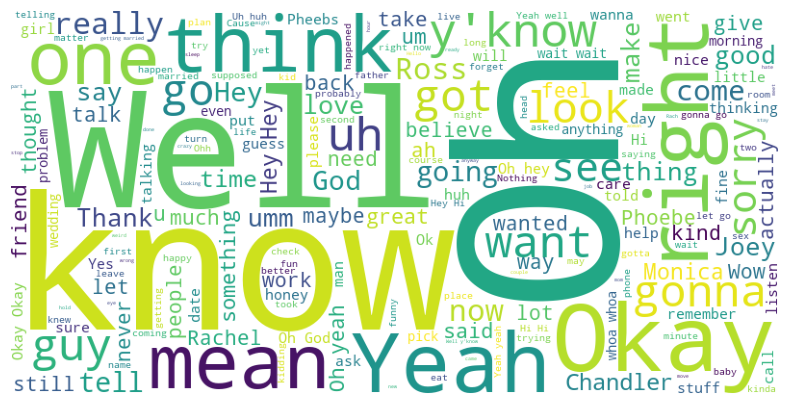

In [13]:
create_wordcloud(df, my_class_index='utterances')


### Defining same useful variables 

A mapping "emotion to integer" and "trigger to integer" is defined as a python dictionary. Furthermore, a padding emotion (z_emotion) is added to the dictionary.

In [14]:
EMOTIONS = np.unique([item for sublist in df["emotions"] for item in sublist])
TRIGGERS = np.unique([item for sublist in df["triggers"] for item in sublist])

EMOTIONS_TO_IDX = {i: emotion for (emotion, i) in enumerate(EMOTIONS)}
IDX_TO_EMOTIONS = {emotion: i for (emotion, i) in enumerate(EMOTIONS)}

EMOTIONS_TO_IDX['z_emotion'] = 7
IDX_TO_EMOTIONS[7] = 'z_emotion' 

EMOTIONS_TO_IDX

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'joy': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6,
 'z_emotion': 7}

### Taking a look to same utterance examples

In [15]:
display_dialogue(dataframe=df, utterance_id='utterance_3359')
display_dialogue(dataframe=df, utterance_id='utterance_456')
display_dialogue(dataframe=df, utterance_id='utterance_2005')


Utterance 3359


,speakers,emotions,utterances,triggers
0,Ross,neutral,Yes that's right.,0.0
1,The Instructor,surprise,Why?,0.0
2,Ross,neutral,"I tired attacking two women, did not work.",0.0
3,The Instructor,surprise,What?!,0.0
4,Ross,neutral,"No, I mean it's okay, I mean, they're-they're ...",0.0
5,Ross,anger,"In fact, I-I-I was married to one of them.",0.0
6,The Instructor,anger,"Let me get this straight man, you attacked you...",0.0
7,Ross,surprise,"Oh, no!",0.0
8,Ross,surprise,No-no!,0.0
9,Ross,surprise,"No, I tired!",1.0



Utterance 456


,speakers,emotions,utterances,triggers
0,Kate,joy,Become a drama critic!,0.0
1,The Director,sadness,I am hurt! A plague on both your houses!,0.0
2,Kate,sadness,"By the way, he dumped me tonight after he read...",0.0
3,Joey,disgust,"Oh, classy.",0.0
4,Kate,sadness,"Yep! I sure know how to pick em, huh? Y'know ...",0.0
5,Joey,anger,"Wow! Yeah I ah, I gave up a job too.",0.0
6,Kate,surprise,Really. What?,0.0
7,Joey,anger,"Uh, de-clawing cats.",0.0
8,Joey,neutral,"Hey, tell ya what.",0.0



Utterance 2005


,speakers,emotions,utterances,triggers
0,Chandler,neutral,"Where you going, Joe?",0.0
1,Joey,neutral,For a walk.,0.0
2,Chandler,neutral,Oh. You mind if I join you?,0.0
3,Joey,neutral,"Actually, that will be long. You know, I reall...",0.0
4,Chandler,surprise,Your thoughts? Plural?,1.0
5,Joey,joy,"Allright, fine, I only have one thought! It's ...",1.0


### Splitting the dataset 


In [16]:
torch.manual_seed(SEED)
np.random.seed(SEED)

train_df, val_df, test_df = split_dataset(df)

print("Training Set: ")
display(train_df)

print("\nValidation Set: ")
display(val_df)

print("\nTest Set: ")
display(test_df)


Training Set: 


,speakers,emotions,utterances,triggers
index,,,,
utterance_555,"[Phoebe, Phoebe]","[sadness, anger]","[Look, I feel really bad about how I freaked y...","[0.0, 0.0]"
utterance_3491,"[Phoebe, Eric, Phoebe, Eric]","[surprise, fear, surprise, sadness]","[You-you you had sex with Ursula?!, Uh, a litt...","[0.0, 0.0, 1.0, 0.0]"
utterance_527,"[Mona, Ross, Dr. Green, Ross]","[fear, neutral, anger, sadness]","[Oh my God! Oh my God! I'm so sorry!, Aw forge...","[0.0, 0.0, 1.0, 0.0]"
utterance_3925,"[Chandler, Chandler, Chandler, Chandler]","[neutral, neutral, neutral, disgust]","[I can blow dry it., I can put gel on it., It ...","[0.0, 0.0, 1.0, 0.0]"
utterance_2989,"[Ross, Phoebe, Ross]","[joy, joy, neutral]",[You're gonna love me so much. I got Sting tic...,"[0.0, 1.0, 0.0]"
...,...,...,...,...
utterance_3939,"[Chandler, Monica, Chandler, Ross, Chandler, R...","[joy, neutral, neutral, surprise, sadness, neu...","[Well, I feel like a snack!, Do you want some ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2523,"[Ross, Kristin, Carol, Susan, Ross, Ross, Ross]","[neutral, neutral, neutral, sadness, neutral, ...","[So, um, what do you do for a living?, Well, u...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
utterance_1683,"[Phoebe, Chandler, Phoebe, Chandler, Phoebe, C...","[joy, neutral, anger, surprise, sadness, surpr...","[Chandler, I found the perfect ring., Oh, that...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"



Validation Set: 


,speakers,emotions,utterances,triggers
index,,,,
utterance_3334,"[Rachel, Tag, Rachel]","[surprise, neutral, joy]","[Oh really?!, Yeah. Did you tell someone that ...","[0.0, 1.0, 0.0]"
utterance_652,"[Phoebe, Duncan, Phoebe, Duncan, Phoebe]","[neutral, surprise, joy, neutral, neutral]","[Hi., Phoebe!, Ta-da., Hey., Hi.]","[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_172,"[Monica, Joey, Monica, Phoebe, Rachel, Joey, R...","[joy, surprise, anger, surprise, neutral, neut...","[Because we won our apartment back!, What? Ace...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3197,"[Older Scientist, Ross, Ross, Joey, Ross, Ross]","[neutral, neutral, neutral, neutral, neutral, ...","[Dr. Geller, there's a seat over here., Thank ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0]"
utterance_38,"[Chandler, Jade, Jade, Chandler]","[neutral, neutral, neutral, joy]","[What've you been up to?, Oh, you know, the us...","[0.0, 1.0, 1.0, 0.0]"
...,...,...,...,...
utterance_1415,"[Roger, Phoebe, Roger, Phoebe, Phoebe, Phoebe,...","[neutral, joy, joy, sadness, sadness, sadness,...","[What's wrong, sweetie?, Nothing, nothing., Aa...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]"
utterance_3610,"[Rachel, Monica, Rachel, Monica, Rachel, Rache...","[disgust, sadness, sadness, joy, sadness, disg...","[Oh God, I hate my job, I hate it, I hate my j...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
utterance_1527,"[Carl, Ross, Rachel, Ross, Ross, Rachel, Ross,...","[disgust, surprise, anger, joy, neutral, neutr...","[I'm just sayin', if I see one more picture of...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"



Test Set: 


,speakers,emotions,utterances,triggers
index,,,,
utterance_3881,"[Joey, Monica, Joey, All, Monica, Joey, Rachel...","[neutral, neutral, joy, disgust, disgust, sadn...","[Hey, y'know what a really good rainy day game...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_2848,"[Janice, Chandler, Janice, Chandler, Janice, C...","[surprise, neutral, surprise, neutral, anger, ...","[Are you being British?!, No. Not anymore., Wh...","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
utterance_1603,"[Rachel, Rachel, Rachel, Ross, Ross, Ross, Ros...","[sadness, sadness, sadness, neutral, neutral, ...",[I'm guess I'm just done with the whole dating...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_160,"[Mr. Tribbiani, Joey, Mr. Tribbiani, Joey]","[sadness, surprise, neutral, neutral]","[Gotta go. I miss you too, I love you, but it'...","[0.0, 0.0, 1.0, 0.0]"
utterance_1704,"[Rachel, Chandler, Rachel, Chandler, Rachel]","[joy, anger, neutral, sadness, surprise]","[Hi!, Another cheesecake came! They delivered ...","[0.0, 0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...
utterance_1130,"[Phoebe, Ross, Phoebe, Chandler, Ross]","[neutral, sadness, fear, anger, neutral]","[Listen, Robert's gonna be here any second so,...","[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1294,"[Chandler, Ross, Joey, Ross, Joey, Ross, Chand...","[neutral, neutral, neutral, neutral, neutral, ...","[Triskaidekaphobia., The fear of, No! No, fear...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_860,"[The Woman, Chandler, The Woman]","[joy, neutral, neutral]","[Yes! Yes! Please, just give it to me!, Yeah, ...","[0.0, 0.0, 0.0]"


### Analyzing the dataset

Some previous studies on the dataset were conducted to search for relevant information and gain a better understanding of the domain we are working in.

####  Dialogues Statistics

In [17]:
total_n_speakers = list(set(df['speakers'].explode()))
speakers = {'min_speakers': 'inf', 'max_speakers': '-inf'}
utterances = {'length_min': 'inf', 'length_max': '-inf'}

num_unique_speakers = df['speakers'].apply(lambda x: len(set(x)))
speakers['min_speakers'] = num_unique_speakers.min()
speakers['max_speakers'] = num_unique_speakers.max()

len_utterances = df['utterances'].str.len() 
utterances['length_min'] = len_utterances.min()
utterances['length_max'] = len_utterances.max()
        
print(f"Number of unique speakers: {len(total_n_speakers)}\n")
print(f"Minimum number of speakers in a dialog: {speakers['min_speakers']}")
print(f"Maximum number of speakers in a dialog: {speakers['max_speakers']}\n")
print(f"Minimum number of sentences in a dialog: {utterances['length_min']}")
print(f"Maximum number of sentences in a dialog: {utterances['length_max']}")


Number of unique speakers: 231

Minimum number of speakers in a dialog: 1
Maximum number of speakers in a dialog: 8

Minimum number of sentences in a dialog: 2
Maximum number of sentences in a dialog: 24


### Data Distribution

In this section, we conducted a study on the distribution of data, and the main observations we made are as follows:

- There is a significant class imbalance in both emotions and triggers, with the "neutral" emotion and the "0" trigger being much more numerous compared to other labels of the same class. This observation led us to define a set of class weights to balance this distribution.
- There are no specific emotions that trigger an emotion flip. For an equal number of occurrences, each emotion triggers the same number of emotion flips.
- Positive triggers are predominantly present in the final part of dialogues, with a peak in the second-to-last utterance of a dialogue.
- The original dataset was partially created using data augmentation, resulting in some dialogues being shorter versions of others, which may lead to a loss of diversity.
- Some utterances (tokenized) are much longer than others. Specifically, only 4 utterances out of 35,000 have a length of 95, while the others have a maximum length of 65, with an average length of 12. This imbalance might cause performance slowdowns depending on the padding policy used (as in our case).

##### Emotions distribution

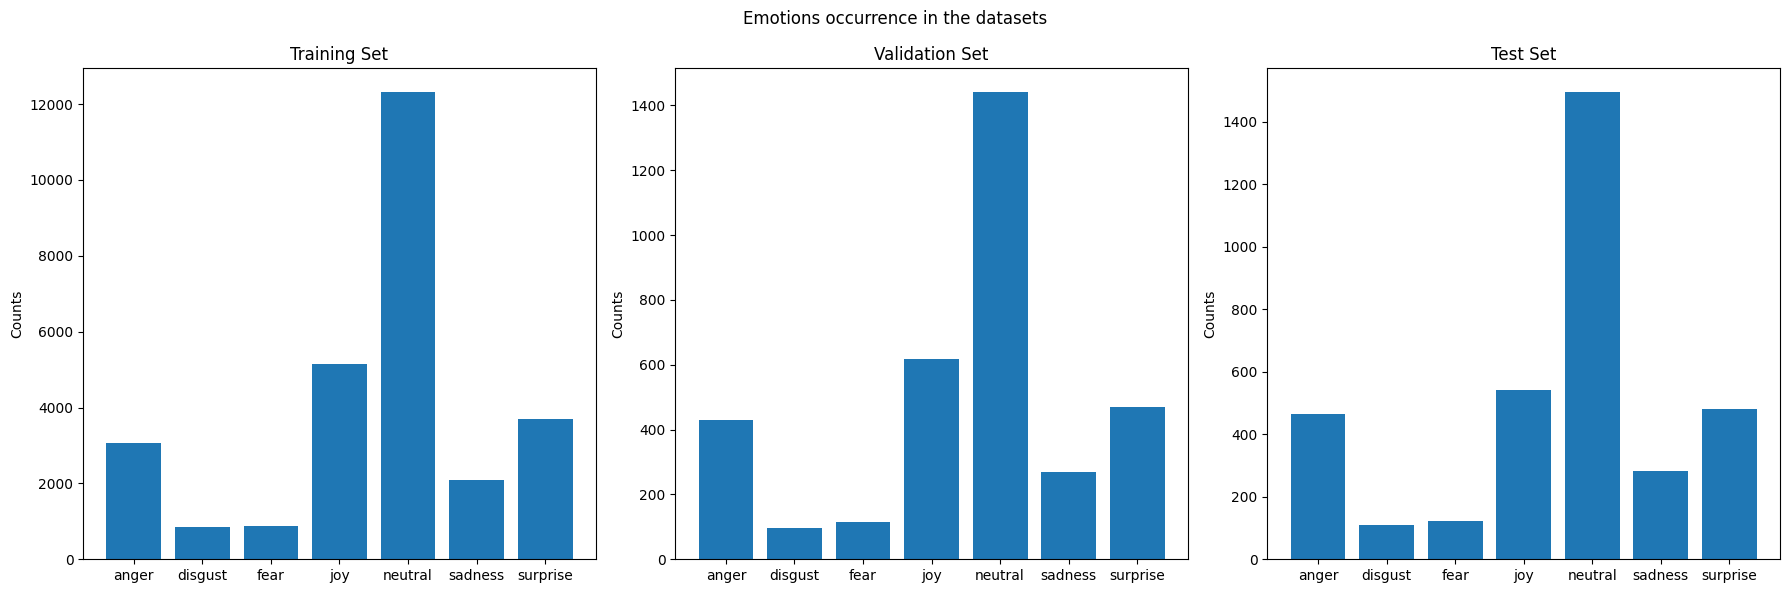

In [18]:
plot_emotion_distribution(train_df, val_df, test_df, column_name='emotions', title="Emotions occurrence in the datasets")


##### Triggers distributions

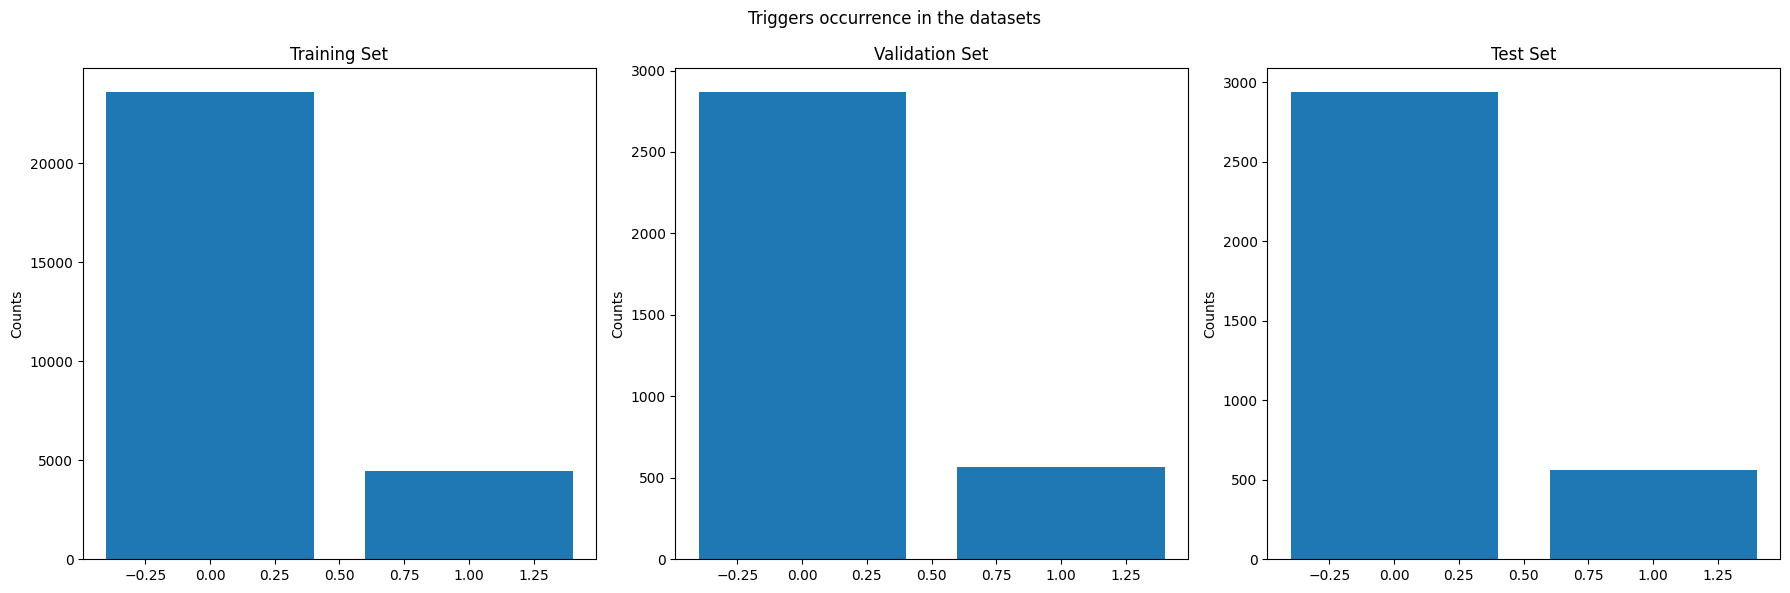

In [19]:
plot_emotion_distribution(train_df, val_df, test_df, column_name='triggers', title="Triggers occurrence in the datasets")


##### Distribution of trigger activation based on emotion 

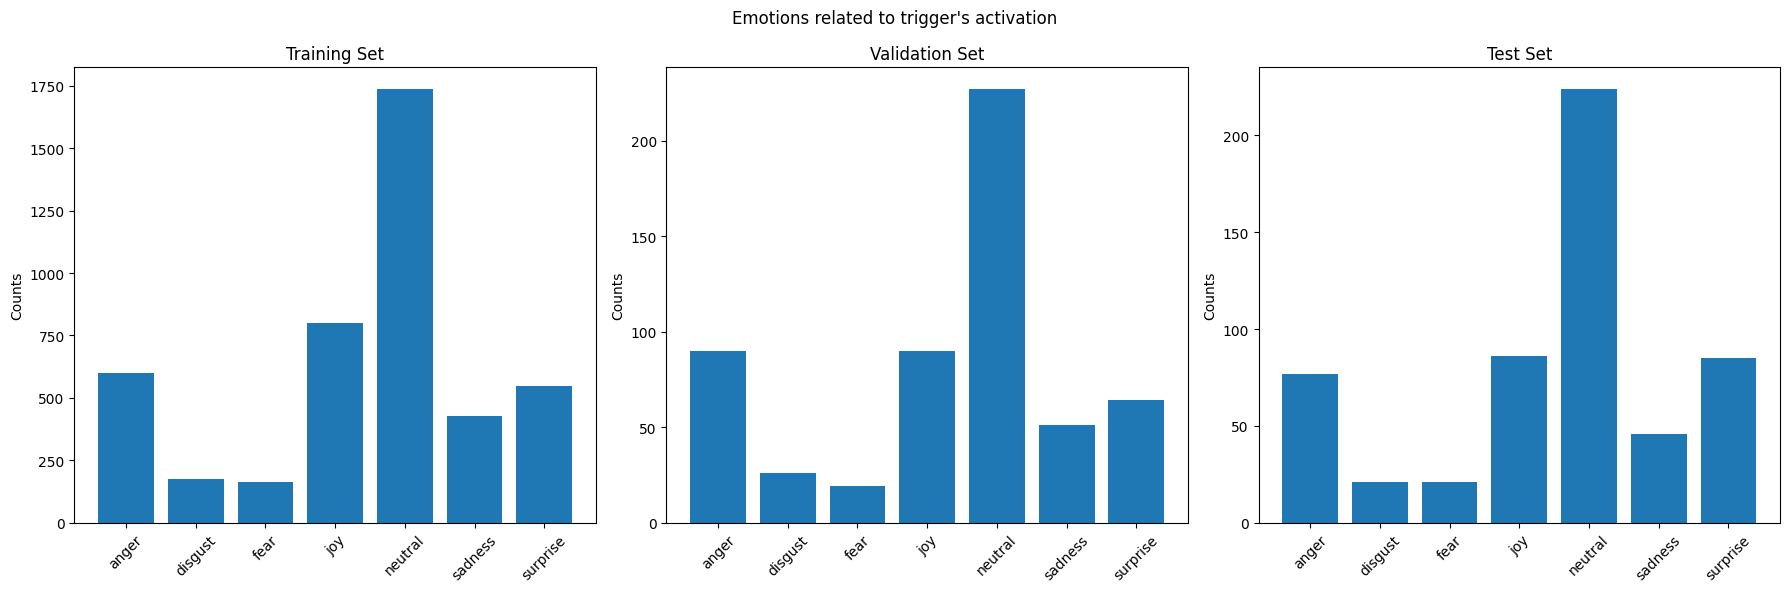

In [20]:
# How many times each emotion activates a trigger
plot_triggers_per_emotion(train_df, val_df, test_df)


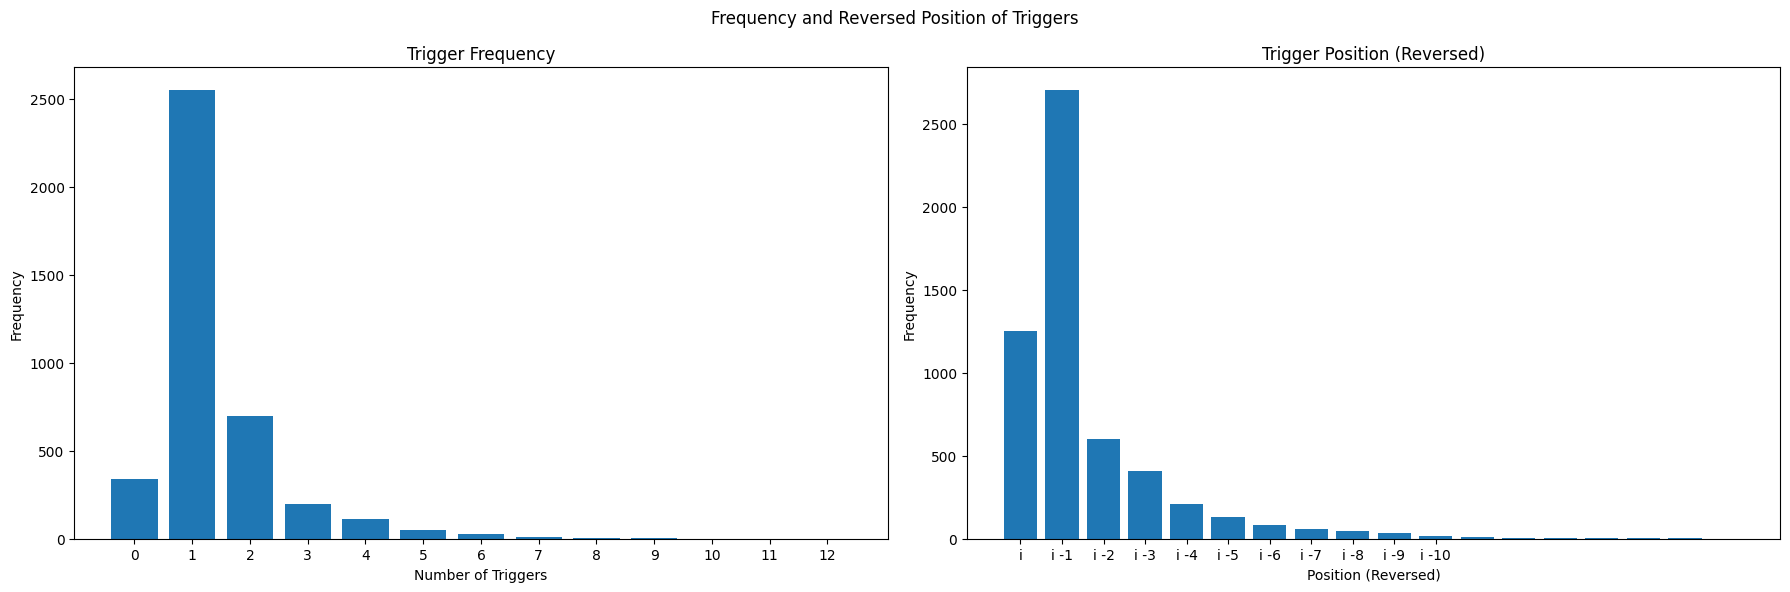

In [21]:
plot_trigger_frequency_and_position_reversed(df["triggers"])

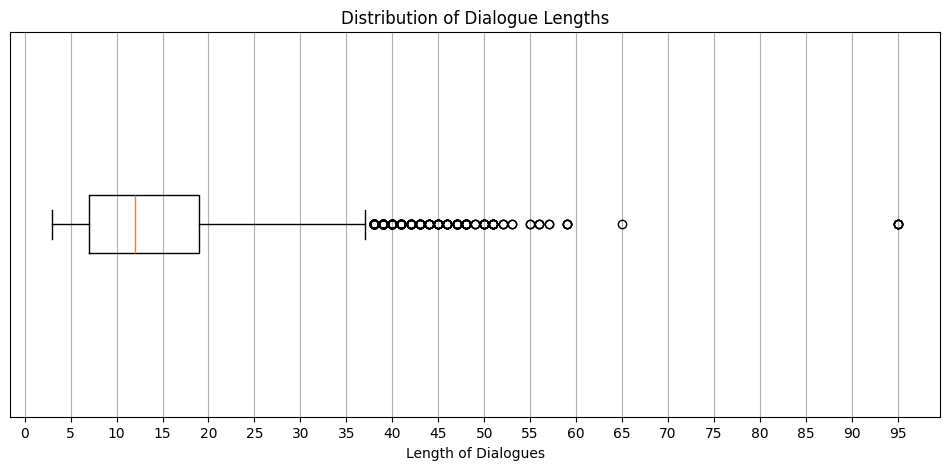

In [22]:
plot_distribution_of_dialogue_lengths(df, bert_tokenizer, figsize=(12,5))

### Computing the class weighs 

As we observed, the classes distribution is unbalanced, hence, it may be useful to define a weight policy to determine the importance of each
class in the computation of the loss function. This importance value is a dynamic trainable parameter of the model that changes along the training
process

$$
w_i = \frac{N}{K \cdot N_i}
$$


Here:
- $N$: is the total number of samples;
- $K$: is the number of classes;
- $N_i$: is a sample of class $i$; 

In this case, every value of emotion and trigger is linked to a weight inversely proportional to their occurrence. The padding label of both of them has $weight = 0$

In [23]:
emotion_weights = create_classes_weights([EMOTIONS_TO_IDX[emotion] for emotion in df['emotions'].sum()])
emotion_weights = np.append(emotion_weights, 0)

trigger_weights = create_classes_weights(df['triggers'].sum())
trigger_weights = np.append(trigger_weights, 0)

padded_emotions = list(EMOTIONS) + ['z_emotion']    
padded_triggers = list(TRIGGERS) + [2]

print('Emotion weights')
display(pd.DataFrame({'Emotion': padded_emotions, 'Weight': emotion_weights}))

print('Trigger weights')
display(pd.DataFrame({'Trigger': padded_triggers, 'Weight': trigger_weights}))


Emotion weights


,Emotion,Weight
0,anger,1.261352
1,disgust,4.766444
2,fear,4.488330
3,joy,0.791515
4,neutral,0.327590
5,sadness,1.888218
6,surprise,1.076426
7,z_emotion,0.000000


Trigger weights


,Trigger,Weight
0,0.0,0.594732
1,1.0,3.139013
2,2.0,0.000000


## Models Training and Results Collection 

### Defining dataframe that are going to contain model's results

In [24]:
f1_per_dialogue_df = pd.DataFrame()
unrolled_and_sequence_f1_df = pd.DataFrame()
emotions_f1_per_class_df = pd.DataFrame()
triggers_f1_per_class_df = pd.DataFrame()


### Random Classifier

In [25]:
if RUN_RANDOM_CLF_PREDICT:
    
    emotion_f1 = F1_Score(name='emotions_F1',
                          mode='macro',
                          num_classes=len(EMOTIONS),
                          pred_transform=lambda x: x,
                          target_transform=lambda x: x)     

    trigger_f1 = F1_Score(name='triggers_F1',
                          mode='macro',
                          num_classes=len(TRIGGERS),
                          pred_transform=lambda x: x,
                          target_transform=lambda x: x)     


    random_classifier = RandomClassifier(EMOTIONS)
    pred_emotions, pred_triggers = random_classifier.predict(test_df)
        
    random_clf_results_df = test_df.copy()
    random_clf_results_df['pred_emotions'] = pred_emotions
    random_clf_results_df['pred_triggers'] = pred_triggers
    
        
    rnd_unrolled_emotions_f1, rnd_unrolled_triggers_f1 = compute_unrolled_f1(emotion_f1=emotion_f1, 
                                                                             trigger_f1=trigger_f1, 
                                                                             targets_emotions=random_clf_results_df['emotions'],
                                                                             predictions_emotions=random_clf_results_df['pred_emotions'],
                                                                             targets_triggers=random_clf_results_df['triggers'],
                                                                             predictions_triggers=random_clf_results_df['pred_triggers'],
                                                                             emotion_to_index=EMOTIONS_TO_IDX)
    
    rnd_f1_per_dialogue_df = compute_f1_per_dialogues(emotion_f1=emotion_f1, 
                                                      trigger_f1=trigger_f1, 
                                                      targets_emotions=random_clf_results_df['emotions'],
                                                      predictions_emotions=random_clf_results_df['pred_emotions'],
                                                      targets_triggers=random_clf_results_df['triggers'],
                                                      predictions_triggers=random_clf_results_df['pred_triggers'],
                                                      emotion_to_index=EMOTIONS_TO_IDX)

    
    emotion_f1.mode='none'
    trigger_f1.mode='none'
    
    rnd_emotions_f1_per_class, rnd_triggers_f1_per_class = compute_unrolled_f1(emotion_f1=emotion_f1, 
                                                                               trigger_f1=trigger_f1, 
                                                                               targets_emotions=random_clf_results_df['emotions'],
                                                                               predictions_emotions=random_clf_results_df['pred_emotions'],
                                                                               targets_triggers=random_clf_results_df['triggers'],
                                                                               predictions_triggers=random_clf_results_df['pred_triggers'],
                                                                               emotion_to_index=EMOTIONS_TO_IDX)
     
    rnd_unrolled_and_sequence_f1_df = pd.DataFrame(data={'random_cls_scores':[rnd_unrolled_emotions_f1, 
                                                                              rnd_unrolled_triggers_f1, 
                                                                              rnd_f1_per_dialogue_df["emotion_f1"].mean(),
                                                                              rnd_f1_per_dialogue_df["trigger_f1"].mean()]},
                                                   index=['unrolled emotion F1 scores',
                                                          'unrolled trigger F1 scores', 
                                                          'sequence emotion F1 score',
                                                          'sequence trigger F1 score'])
            
    
    rnd_emotions_f1_per_class_df = pd.DataFrame(rnd_emotions_f1_per_class, index=EMOTIONS, columns=['random_scores'])
    rnd_triggers_f1_per_class_df = pd.DataFrame(rnd_triggers_f1_per_class, columns=['random_scores'] )
    
    random_clf_results_df['triggers'] = random_clf_results_df['triggers'].apply(lambda l: [int(x) for x in l])

    random_clf_results_df.index.name = 'index'
    rnd_f1_per_dialogue_df.index.name = 'episode'
    rnd_unrolled_and_sequence_f1_df.index.name = 'metrics'
    rnd_emotions_f1_per_class_df.index.name = 'emotions'
    rnd_triggers_f1_per_class_df.index.name = 'triggers'
    rnd_f1_per_dialogue_df.columns = ['random_'+ c_n for c_n in rnd_f1_per_dialogue_df.columns]
    
    # Saving Random cls results
    random_clf_results_df.to_csv(RND_PREDICTIONS_DF_PATH)
    rnd_f1_per_dialogue_df.to_csv(RND_F1_DIALOGUE_DF_PATH)
    rnd_unrolled_and_sequence_f1_df.to_csv(RND_UNROLLED_AND_SEQUENCE_F1_DF_PATH)
    rnd_emotions_f1_per_class_df.to_csv(RND_F1_PER_EMOTION_CLASSES_DF_PATH)
    rnd_triggers_f1_per_class_df.to_csv(RND_F1_PER_TRIGGER_CLASSES_DF_PATH)
    
else:
    # Loading Random cls results
    random_clf_results_df = pd.read_csv(RND_PREDICTIONS_DF_PATH, index_col=0)
    rnd_f1_per_dialogue_df = pd.read_csv(RND_F1_DIALOGUE_DF_PATH, index_col=0)
    rnd_unrolled_and_sequence_f1_df = pd.read_csv(RND_UNROLLED_AND_SEQUENCE_F1_DF_PATH, index_col=0)
    rnd_emotions_f1_per_class_df = pd.read_csv(RND_F1_PER_EMOTION_CLASSES_DF_PATH, index_col=0)
    rnd_triggers_f1_per_class_df = pd.read_csv(RND_F1_PER_TRIGGER_CLASSES_DF_PATH, index_col=0)


# Merging Random results to de file result dfs
f1_per_dialogue_df = f1_per_dialogue_df.merge(rnd_f1_per_dialogue_df, how='outer', left_index=True, right_index=True)
unrolled_and_sequence_f1_df = unrolled_and_sequence_f1_df.merge(rnd_unrolled_and_sequence_f1_df, how='outer', left_index=True, right_index=True)
emotions_f1_per_class_df = emotions_f1_per_class_df.merge(rnd_emotions_f1_per_class_df, how='outer', left_index=True, right_index=True)
triggers_f1_per_class_df = triggers_f1_per_class_df.merge(rnd_triggers_f1_per_class_df, how='outer', left_index=True, right_index=True)


### Majority Classifier

In [26]:
if RUN_MAJORITY_CLf_PREDICT:
    
    emotion_f1 = F1_Score(name='emotions_F1',
                          mode='macro',
                          num_classes=len(EMOTIONS),
                          pred_transform=lambda x: x,
                          target_transform=lambda x: x)     

    trigger_f1 = F1_Score(name='triggers_F1',
                          mode='macro',
                          num_classes=len(TRIGGERS),
                          pred_transform=lambda x: x,
                          target_transform=lambda x: x)     
    
    
    majority_classifier = MajorityClassifier()
    majority_classifier.fit(train_df)
    pred_emotions, pred_triggers = majority_classifier.predict(test_df)
    
    majority_clf_results_df = test_df.copy()
    majority_clf_results_df['pred_emotions'] = pred_emotions
    majority_clf_results_df['pred_triggers'] = pred_triggers
    
    
    mjr_unrolled_emotions_f1, mjr_unrolled_triggers_f1 = compute_unrolled_f1(emotion_f1=emotion_f1, 
                                                                             trigger_f1=trigger_f1, 
                                                                             targets_emotions=majority_clf_results_df['emotions'],
                                                                             predictions_emotions=majority_clf_results_df['pred_emotions'],
                                                                             targets_triggers=majority_clf_results_df['triggers'],
                                                                             predictions_triggers=majority_clf_results_df['pred_triggers'],
                                                                             emotion_to_index=EMOTIONS_TO_IDX)
           
    mjr_f1_per_dialogue_df = compute_f1_per_dialogues(emotion_f1=emotion_f1, 
                                                      trigger_f1=trigger_f1, 
                                                      targets_emotions=majority_clf_results_df['emotions'],
                                                      predictions_emotions=majority_clf_results_df['pred_emotions'],
                                                      targets_triggers=majority_clf_results_df['triggers'],
                                                      predictions_triggers=majority_clf_results_df['pred_triggers'],
                                                      emotion_to_index=EMOTIONS_TO_IDX)
    
    
    emotion_f1.mode='none'
    trigger_f1.mode='none'
    
    mjr_emotions_f1_per_class, mjr_triggers_f1_per_class = compute_unrolled_f1(emotion_f1=emotion_f1, 
                                                                              trigger_f1=trigger_f1, 
                                                                              targets_emotions=majority_clf_results_df['emotions'],
                                                                              predictions_emotions=majority_clf_results_df['pred_emotions'],
                                                                              targets_triggers=majority_clf_results_df['triggers'],
                                                                              predictions_triggers=majority_clf_results_df['pred_triggers'],
                                                                              emotion_to_index=EMOTIONS_TO_IDX)
    
    mjr_unrolled_and_sequence_f1_df = pd.DataFrame(data={'majority_cls_scores':[mjr_unrolled_emotions_f1, 
                                                                                mjr_unrolled_triggers_f1, 
                                                                                mjr_f1_per_dialogue_df["emotion_f1"].mean(),
                                                                                mjr_f1_per_dialogue_df["trigger_f1"].mean()]},
                                                   index=['unrolled emotion F1 scores', 
                                                          'unrolled trigger F1 scores', 
                                                          'sequence emotion F1 score', 
                                                          'sequence trigger F1 score'])            
            
    
    mjr_emotions_f1_per_class_df = pd.DataFrame(mjr_emotions_f1_per_class, index=EMOTIONS, columns=['majority_scores'])
    mjr_triggers_f1_per_class_df = pd.DataFrame(mjr_triggers_f1_per_class,columns=['majority_scores'] )
    
    
    majority_clf_results_df['triggers'] = random_clf_results_df['triggers'].apply(lambda l: [int(x) for x in l])
    
    
    mjr_f1_per_dialogue_df.columns = ['majority_' + c_n for c_n in mjr_f1_per_dialogue_df.columns]
    majority_clf_results_df.index.name = 'index'
    mjr_f1_per_dialogue_df.index.name = 'episode'
    mjr_unrolled_and_sequence_f1_df.index.name = 'metrics'
    mjr_emotions_f1_per_class_df.index.name = 'emotions'
    mjr_triggers_f1_per_class_df.index.name = 'triggers'
    
    # Saving Majority cls results
    majority_clf_results_df.to_csv(MJR_PREDICTIONS_DF_PATH)
    mjr_f1_per_dialogue_df.to_csv(MJR_F1_DIALOGUE_DF_PATH)
    mjr_unrolled_and_sequence_f1_df.to_csv(MJR_UNROLLED_AND_SEQUENCE_F1_DF_PATH)
    mjr_emotions_f1_per_class_df.to_csv(MJR_F1_PER_EMOTION_CLASSES_DF_PATH)
    mjr_triggers_f1_per_class_df.to_csv(MJR_F1_PER_TRIGGER_CLASSES_DF_PATH)

else:
    # Loading Majority cls results
    majority_clf_results_df = pd.read_csv(MJR_PREDICTIONS_DF_PATH, index_col=0)
    mjr_f1_per_dialogue_df = pd.read_csv(MJR_F1_DIALOGUE_DF_PATH, index_col=0)
    mjr_unrolled_and_sequence_f1_df = pd.read_csv(MJR_UNROLLED_AND_SEQUENCE_F1_DF_PATH, index_col=0)
    mjr_emotions_f1_per_class_df = pd.read_csv(MJR_F1_PER_EMOTION_CLASSES_DF_PATH, index_col=0)
    mjr_triggers_f1_per_class_df = pd.read_csv(MJR_F1_PER_TRIGGER_CLASSES_DF_PATH, index_col=0)
    

# Merging Majority results to de file result dfs        
f1_per_dialogue_df = f1_per_dialogue_df.merge(mjr_f1_per_dialogue_df, how='outer', left_index=True, right_index=True)
unrolled_and_sequence_f1_df = unrolled_and_sequence_f1_df.merge(mjr_unrolled_and_sequence_f1_df, how='outer', left_index=True, right_index=True)
emotions_f1_per_class_df = emotions_f1_per_class_df.merge(mjr_emotions_f1_per_class_df, how='outer', left_index=True, right_index=True)
triggers_f1_per_class_df = triggers_f1_per_class_df.merge(mjr_triggers_f1_per_class_df, how='outer', left_index=True, right_index=True)
    

### Bert Models

#### Data Loaders creation

In [27]:
torch.manual_seed(SEED)
np.random.seed(SEED)


dataLoaderBuilder = DataLoaderFromPipelineStrategy()

max_tokenized_length =  find_max_encoded_utterance_len(bert_tokenizer, df['utterances'])

my_tokenization_f = partial(tokenize_data, max_tokenized_length=max_tokenized_length,tokenizer=bert_tokenizer)


# BertFreezed Dataloaders
train_dataloader_freezed = dataLoaderBuilder.create(data=train_df['utterances'],
                                                    labels=train_df[['emotions', 'triggers']],
                                                    shuffle=True,
                                                    data_preprocess_f=my_tokenization_f,
                                                    labels_preprocess_f=preprocess_labels,
                                                    batch_size=BATCH_SIZE_FREEZED,
                                                    device=device)
 
val_dataloader_freezed = dataLoaderBuilder.create(data=val_df['utterances'],
                                                  labels=val_df[['emotions', 'triggers']],
                                                  shuffle=False,
                                                  data_preprocess_f=my_tokenization_f,
                                                  labels_preprocess_f=preprocess_labels,
                                                  batch_size=BATCH_SIZE_FREEZED,
                                                  device=device)
 
test_dataloader_freezed = dataLoaderBuilder.create(data=test_df['utterances'],
                                                   labels=test_df[['emotions', 'triggers']],
                                                   shuffle=False,
                                                   data_preprocess_f=my_tokenization_f,
                                                   labels_preprocess_f=preprocess_labels,
                                                   batch_size=BATCH_SIZE_FREEZED,
                                                   device=device)   


# BertFull Dataloaders
train_dataloader_full = dataLoaderBuilder.create(data=train_df['utterances'],
                                                 labels=train_df[['emotions', 'triggers']],
                                                 shuffle=True,
                                                 data_preprocess_f=my_tokenization_f,
                                                 labels_preprocess_f=preprocess_labels,
                                                 batch_size=BATCH_SIZE_FULL,
                                                 device=device)

val_dataloader_full = dataLoaderBuilder.create(data=val_df['utterances'],
                                               labels=val_df[['emotions', 'triggers']],
                                               shuffle=False,
                                               data_preprocess_f=my_tokenization_f,
                                               labels_preprocess_f=preprocess_labels,
                                               batch_size=BATCH_SIZE_FULL,
                                               device=device)

test_dataloader_full = dataLoaderBuilder.create(data=test_df['utterances'],
                                                labels=test_df[['emotions', 'triggers']],
                                                shuffle=False,
                                                data_preprocess_f=my_tokenization_f,
                                                labels_preprocess_f=preprocess_labels,
                                                batch_size=BATCH_SIZE_FULL,
                                                device=device)  
 
input_data_freezed, _ = next(iter(train_dataloader_freezed))
input_data_full, _ = next(iter(train_dataloader_full))

n_token_per_utterance = input_data_freezed['input_ids'].shape[-1]


#### Defining Metrics to use in grid search and fit section

In [28]:
##### Metrics definitions and combination

# F1s definition

# Definition of single head Unrolled F1 
unrolled_emotion_f1 = F1_Score(name='unrolled_emotions_F1',
                              mode='macro',
                              num_classes=len(padded_emotions),
                              classes_to_exclude=[7])     

unrolled_trigger_f1 = F1_Score(name='unrolled_triggers_F1',
                               mode='macro',
                               num_classes=len(padded_triggers),
                               classes_to_exclude=[2])   
           
# Combining Single head Unrolled F1 into Multi Head Metric
unrolled_multi_head_f1 = MultiHeadMetric(name='agg_unrolled_F1',
                                         metrics_functions={'emotions': unrolled_emotion_f1,
                                                            'triggers': unrolled_trigger_f1},
                                         metric_weights={'emotions': 1, 
                                                         'triggers': 1},
                                         aggregate_metrics_function=torch.mean)
 
# Definition of single head sequence F1 
sequence_avg_emotion_f1 = F1_Score(name='sequence_emotions_F1',
                                   mode='macro',
                                   num_classes=len(padded_emotions),
                                   classes_to_exclude=[7])     

sequence_avg_trigger_f1 = F1_Score(name='sequence_triggers_F1',
                                   mode='macro',
                                   num_classes=len(padded_triggers),
                                   classes_to_exclude=[2])     
                 
# Wrapping DrTorch F1_score into custom Metric objects that allow to compute the metrics separately for each dialog and then obtain the main 
sequence_emotion_f1 = Sentence_F1(f1_obj=sequence_avg_emotion_f1,
                                 key_to_consider='emotions')

sequence_trigger_f1 = Sentence_F1(f1_obj=sequence_avg_trigger_f1,
                                  key_to_consider='triggers')

# Combining Single head sentence F1 into Multi Head Metric
sentence_multi_head_f1 = MultiHeadMetric(name='agg_sequence_F1',
                                         metrics_functions={'emotions': sequence_emotion_f1,
                                                            'triggers': sequence_trigger_f1},
                                         metric_weights={'emotions': 1, 
                                                         'triggers': 1},
                                         aggregate_metrics_function=torch.mean)


# Accuracy definition
emotion_accuracy = Accuracy(name='emotions_accuracy',
                            num_classes=len(padded_emotions),
                            classes_to_exclude=[7])     

trigger_accuracy = Accuracy(name='triggers_accuracy',
                            num_classes=len(padded_triggers),
                            classes_to_exclude=[2])     

multi_head_accuracy = MultiHeadMetric(name='agg_avg_accuracy',
                                      metrics_functions={'emotions': emotion_accuracy,
                                                         'triggers': trigger_accuracy},
                                      metric_weights={'emotions': 1, 
                                                      'triggers': 1},
                                      aggregate_metrics_function=torch.mean)


# Recall definition
emotion_recall = Recall(name='emotions_recall',
                        num_classes=len(padded_emotions),
                        classes_to_exclude=[7])     

trigger_recall = Recall(name='triggers_recall',
                        num_classes=len(padded_triggers),
                        classes_to_exclude=[2])     

multi_head_recall = MultiHeadMetric(name='agg_avg_recall',
                                    metrics_functions={'emotions': emotion_recall,
                                                       'triggers': trigger_recall},
                                    metric_weights={'emotions': 1, 
                                                    'triggers': 1},
                                    aggregate_metrics_function=torch.mean)


# Precision definition
emotion_precision = Precision(name='emotions_precision',
                              num_classes=len(padded_emotions),
                              classes_to_exclude=[7])     

trigger_precision = Precision(name='triggers_precision',
                              num_classes=len(padded_triggers),
                              classes_to_exclude=[2])     
      
multi_head_precision = MultiHeadMetric(name='agg_avg_precision',
                                       metrics_functions={'emotions': emotion_precision,
                                                          'triggers': trigger_precision},
                                       metric_weights={'emotions': 1, 
                                                        'triggers': 1},
                                       aggregate_metrics_function=torch.mean)
   

#### Defining same useful functions

These auxiliary functions send data to a Wandb webpage which stores and plot the data in real-time during the grid search and the training phase.

In [29]:
# Function to send a sample to wandb during the training process of the best models 
def send_a_predicted_sample_to_wandb(model: BertOne):
    """
    An auxiliary function used to send Wandb the predictions of an element extracted from the test set during training 
    to monitor how the model's predictions improve during the during various epochs  
        
    """
    
    model.eval()

    sample_to_send = test_df.iloc[0].copy()
    input  = next(iter(test_dataloader_freezed))[0]
    input = {key:input[key][0].unsqueeze(0).to(device) for key in input.keys()}
    prediction = model(input)
    prediction = {key: torch.argmax(prediction[key], dim=-1).view(-1).detach().cpu() for key in prediction.keys()}
    
    table_data = []
    for column_value in sample_to_send:
        table_data.append(column_value)
    
    new_df = pd.DataFrame(table_data).transpose()
    new_df.columns = sample_to_send.index
    
    new_df['pred_emotion'] = [IDX_TO_EMOTIONS[emotion] for emotion in prediction['emotions'].tolist()][: len(new_df)]
    new_df['pred_emotion'] = new_df['pred_emotion'].apply(lambda x: str(x))

    new_df['pred_triggers'] = prediction['triggers'].tolist()[: len(new_df)]
    
    return {'sample_of_predictions': wandb.Table(dataframe=new_df)}


# DataLoaderFromPipelineStrategy.create() unpacking parameter logic
def my_logic(param, _):
    """
    This function is an auxiliary function for the creation of dataloaders inside the grid search 
    
    """
    if param == 'data_preprocess_f':
        max_tokenized_length = find_max_encoded_utterance_len(bert_tokenizer, df['utterances'])
        additional_parm  = partial(tokenize_data, max_tokenized_length=max_tokenized_length, tokenizer=bert_tokenizer)
    elif param == 'labels_preprocess_f':
        additional_parm = preprocess_labels
    elif param == 'pin_memory':
        additional_parm = True
    elif param == 'num_workers':
        additional_parm = 10
    elif param == 'sample_preprocess_f':
        additional_parm = None
    elif param == 'label_preprocess_f':
        additional_parm = None
    else:
        raise AttributeError (f'DataLoaderFromPipelineStrategy.create() require attribute {param}')
    
    return additional_parm

    

#### Freezed BertOne

##### Grid Search Freezed BertOne 

Once a good subset of hyperparameters is defined, a grid search is conducted to iterate over five seeds to determine whether to use the class weights defined above. Despite the class imbalance, the presence of class weights is not beneficial for the overall performance of the model, leading to a decrease of a few percentage points in almost every training configuration.

A grid search is conducted to iterate over five seeds to determine whether to use the class weights defined above. The robustness of the results are verifying repeating the experiments with five different seeds


In [2]:
if RUN_FREEZED_BERTONE_GRID_SEARCH:
    
    #creating Wandb config params 
    if INTERACT_WITH_WANDB:
        wandb_params = {'project': 'Emotion-flip-reasoning',
                        'tags': ['Deep Learning', 'NLP'],
                        'entity': "nlp_course_project"}
    else:
        wandb_params = None

    hyperparameters_key_to_save = ['criterion', 'name']
    optimizers = [OptimizerWrapper(torch.optim.Adam, identifier=f'lr={1e-3}', optimizer_partial_params={'lr':1e-3})]

    # Defining single Head Criterion
    emotion_criterion = Criterion(name='emotion_cross_entropy',
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),
                                  reshape_loss_input_f=reshape_loss_input)

    trigger_criterion = Criterion(name='trigger_cross_entropy',
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),
                                  reshape_loss_input_f=reshape_loss_input)
    
    
    # Defining single Head Criterion that use class weights
    emotion_criterion_w_ce = Criterion(name='emotion_cross_entropy',
                                       loss_function=torch.nn.CrossEntropyLoss(reduction='none', weight=torch.tensor(emotion_weights, device=device)),
                                       reshape_loss_input_f=reshape_loss_input)

    trigger_criterion_w_ce = Criterion(name='trigger_cross_entropy',
                                       loss_function=torch.nn.CrossEntropyLoss(reduction='none', weight=torch.tensor(trigger_weights, device=device)),
                                       reshape_loss_input_f=reshape_loss_input)


    # Aggregate single head criteria into a multi-head criteria 
    multi_head_criterion = MultiHeadCriterion(name='CE_loss',
                                              loss_functions={'emotions': emotion_criterion,
                                                              'triggers': trigger_criterion},
                                              loss_weights={'emotions':1, 
                                                            'triggers':1},
                                              reduction_function=torch.mean)

    
    # Aggregate single head criteria that use class weights into a multi-head criteria
    multi_head_criterion_w_cw = MultiHeadCriterion(name='CE_loss_w_cw',
                                                   loss_functions={'emotions': emotion_criterion_w_ce,
                                                                   'triggers': trigger_criterion_w_ce},
                                                   loss_weights={'emotions':1, 
                                                                 'triggers':1},
                                                   reduction_function=torch.mean)

    
    # List of the criteria to test
    criteria = [multi_head_criterion_w_cw,  multi_head_criterion]


    # Early Stoppers definitions and combination
    early_stopper_e = EarlyStopper(monitor='unrolled_emotions_F1',
                                   patience=PATIENCE, 
                                   delta=DELTA, 
                                   mode='max')

    early_stopper_t = EarlyStopper(monitor='unrolled_triggers_F1',
                                   patience=PATIENCE,
                                   delta=DELTA, 
                                   mode='max')
    
    # Layers that we want to freeze using the MultipleEarlyStoppers object
    emotion_head_layers = ['emotion_classifier.0.weight', 'emotion_classifier.0.bias', 'emotion_classifier.2.weight', 'emotion_classifier.2.bias']
    trigger_head_layers = ['trigger_classifier.0.weight', 'trigger_classifier.0.bias', 'trigger_classifier.2.weight', 'trigger_classifier.2.bias']
    
    # Aggregate the single early stoppers into a multiple early stoppers 
    multiple_stopper = MultipleEarlyStoppers(stoppers={'emotions':  early_stopper_e, 
                                                      'triggers': early_stopper_t},
                                             layers_to_freeze={'emotions': emotion_head_layers,
                                                               'triggers': trigger_head_layers},
                                             restore_weights=True)
    
    
    model_hyperparameters_to_test=[{'model_class': BertOne,
                                    'bert_model': bert_model,
                                    'n_emotions': len(padded_emotions),
                                    'n_triggers': len(padded_triggers),
                                    'cls_input_size': n_token_per_utterance * BERT_HIDDEN_DIM,
                                    'hidden_dim': 512,
                                    'freeze_bert_weights': True,
                                    'name': 'Freezed Bertone'}]

    training_hyperparameters_to_test = [{'num_epochs': MAX_N_EPOCH,
                                         'optimizer': optimizer,
                                         'batch_size': BATCH_SIZE_FREEZED,
                                         'criterion': current_criterion,
                                         'early_stopper': multiple_stopper,
                                         'interaction_with_wandb': INTERACT_WITH_WANDB, 
                                         'metrics': [unrolled_multi_head_f1, sentence_multi_head_f1, multi_head_accuracy, multi_head_recall, multi_head_precision],
                                         } for optimizer, current_criterion in itertools.product(optimizers, criteria)]


    dataLoaderBuilder = DataLoaderFromPipelineStrategy(logic=partial(my_logic))
        
    grid_search_train_validation(train_data=(train_df['utterances'], train_df[['emotions', 'triggers']]),
                                 val_data=(val_df['utterances'], val_df[['emotions', 'triggers']]),
                                 dataloader_builder=dataLoaderBuilder,
                                 shuffle=True,
                                 model_hyperparameters_to_test=model_hyperparameters_to_test,
                                 training_hyperparameters_to_test=training_hyperparameters_to_test,
                                 hyperparameters_key_to_save=hyperparameters_key_to_save,
                                 device=device,
                                 path_to_save_grid_search_results=FREEZED_BERTONE_GRID_SEARCH_RESULTS_PATH,
                                 seeds=SEEDS,
                                 save_loss_values=True,
                                 wandb_params=wandb_params)


100%|██████████| 2/2 [24:10:13<00:00, 43506.69s/it]


##### Visualizing grid search results for Freezed Bertone  

In [30]:
# Results of the single configurations
freezed_grid_result_df = joblib.load(FREEZED_BERTONE_GRID_SEARCH_RESULTS_PATH)
freezed_grid_result_df


,criterion,name,time,seed,train_loss,val_loss,agg_unrolled_F1_train,agg_unrolled_F1_val,unrolled_emotions_F1_train,unrolled_emotions_F1_val,...,emotions_recall_train,emotions_recall_val,triggers_recall_train,triggers_recall_val,agg_avg_precision_train,agg_avg_precision_val,emotions_precision_train,emotions_precision_val,triggers_precision_train,triggers_precision_val
0,CE_loss_w_cw,Freezed Bertone,10551.374095,42,0.226638,0.701986,0.805393,0.616433,0.966993,0.741960,...,0.433907,0.375500,0.285739,0.255761,0.335786,0.289634,0.426580,0.370853,0.253215,0.222136
1,CE_loss_w_cw,Freezed Bertone,10343.262654,69,0.292995,0.733756,0.749214,0.568994,0.973186,0.749420,...,0.431427,0.369370,0.284834,0.251771,0.320180,0.281783,0.431730,0.381238,0.246284,0.220242
2,CE_loss_w_cw,Freezed Bertone,7392.977239,90,0.368147,0.756724,0.714635,0.582265,0.938505,0.709807,...,0.429740,0.363427,0.267648,0.250244,0.308223,0.275349,0.418061,0.367883,0.244535,0.221470
3,CE_loss_w_cw,Freezed Bertone,8166.988546,1,0.209570,0.746671,0.827693,0.620761,0.952478,0.719641,...,0.429792,0.360767,0.289672,0.254462,0.341949,0.294455,0.424054,0.375094,0.266038,0.221548
4,CE_loss_w_cw,Freezed Bertone,8862.293557,77,0.393416,0.886945,0.717673,0.573019,0.959122,0.733756,...,0.431366,0.363407,0.267114,0.243957,0.311793,0.275783,0.425586,0.382904,0.246949,0.217178
5,CE_loss,Freezed Bertone,8877.142003,42,0.228501,0.531239,0.777822,0.639145,0.977811,0.760008,...,0.432539,0.368238,0.233773,0.225661,0.349994,0.302797,0.432684,0.390897,0.282474,0.233818
6,CE_loss,Freezed Bertone,6679.101948,69,0.189891,0.504976,0.821378,0.650751,0.970440,0.759171,...,0.430898,0.371337,0.250070,0.238177,0.354410,0.299035,0.431017,0.385509,0.280376,0.229604
7,CE_loss,Freezed Bertone,11828.760653,90,0.298889,0.608855,0.743066,0.617339,0.991849,0.780673,...,0.436120,0.376338,0.254417,0.242064,0.328366,0.291358,0.435307,0.392905,0.262197,0.232144
8,CE_loss,Freezed Bertone,8149.193961,1,0.194473,0.523317,0.793146,0.641157,0.973949,0.754517,...,0.430698,0.364759,0.230012,0.211610,0.358575,0.306718,0.432834,0.391859,0.290101,0.229839
9,CE_loss,Freezed Bertone,5946.546352,77,0.152025,0.474936,0.814415,0.663925,0.966232,0.746713,...,0.428154,0.360209,0.236165,0.223748,0.365507,0.314565,0.431884,0.391850,0.299131,0.237280


In [31]:
# Averaged results over the 5 seeds
freezed_grid_result_df['criterion'] = freezed_grid_result_df['criterion'].apply(lambda x: x.name) 
column_to_consider = [column_name for column_name in freezed_grid_result_df.keys() if column_name not in ['criterion', 'name', 'seed']]
statistics_df = freezed_grid_result_df.groupby('criterion')[column_to_consider].agg(['mean', 'std'])

pd.set_option('display.max_columns', None) 
statistics_df


time              train_loss            val_loss  \
                     mean          std       mean       std      mean   
criterion                                                               
CE_loss       8296.148983  2289.867218   0.212756  0.055255  0.528664   
CE_loss_w_cw  9063.379218  1368.066593   0.298153  0.082101  0.765216   

                       agg_unrolled_F1_train           agg_unrolled_F1_val  \
                   std                  mean       std                mean   
criterion                                                                    
CE_loss       0.049784              0.789965  0.031392            0.642463   
CE_loss_w_cw  0.071102              0.762921  0.051396            0.592294   

                       unrolled_emotions_F1_train            \
                   std                       mean       std   
criterion                                                     
CE_loss       0.017126                   0.976056  0.009811   
CE_loss_w_cw  0.024536                   0.958057  0.013447   

             unrolled_emotions_F1_val           unrolled_triggers_F1_train  \
                                 mean       std                       mean   
criterion                                                                    
CE_loss                      0.760216  0.012594                   0.658748   
CE_loss_w_cw                 0.730917  0.016164                   0.665101   

                       unrolled_triggers_F1_val            \
                   std                     mean       std   
criterion                                                   
CE_loss       0.016578                 0.577810  0.013366   
CE_loss_w_cw  0.034194                 0.525935  0.026499   

             agg_sequence_F1_train           agg_sequence_F1_val            \
                              mean       std                mean       std   
criterion                                                                    
CE_loss                   0.514426  0.019786            0.436544  0.010670   
CE_loss_w_cw              0.525066  0.041026            0.419719  0.018909   

             sequence_emotions_F1_train           sequence_emotions_F1_val  \
                                   mean       std                     mean   
criterion                                                                    
CE_loss                        0.471237  0.014159                 0.367822   
CE_loss_w_cw                   0.477811  0.009546                 0.370451   

                       sequence_triggers_F1_train            \
                   std                       mean       std   
criterion                                                     
CE_loss       0.009625                   0.581069  0.020050   
CE_loss_w_cw  0.010263                   0.627306  0.033309   

             sequence_triggers_F1_val           agg_avg_accuracy_train  \
                                 mean       std                   mean   
criterion                                                                
CE_loss                      0.526432  0.016030                0.89412   
CE_loss_w_cw                 0.510376  0.012898                0.81906   

                       agg_avg_accuracy_val           emotions_accuracy_train  \
                   std                 mean       std                    mean   
criterion                                                                       
CE_loss       0.029374             0.767021  0.023995                0.977350   
CE_loss_w_cw  0.042286             0.650756  0.026993                0.952683   

                       emotions_accuracy_val            \
                   std                  mean       std   
criterion                                                
CE_loss       0.008762              0.799127  0.010240   
CE_loss_w_cw  0.014860              0.765086  0.016495   

             triggers_accuracy_train           triggers_accuracy_val  \
             

##### Creation of Freezed BertOne for Single Execution

In [32]:
torch.manual_seed(SEED)
np.random.seed(SEED)

freezed_bertOne = BertOne(bert_model=bert_model,
                          n_emotions=len(padded_emotions),
                          n_triggers=len(padded_triggers),
                          cls_input_size=n_token_per_utterance * BERT_HIDDEN_DIM,
                          hidden_dim=512,
                          freeze_bert_weights=True,
                          name='FreezedBertOne').to(device)


##### Summary of the Model 

In [33]:
freezed_bertOne.summary(input_data_freezed, verbose=True)


--------------------------------------------------------------------
             Layer (type)               Output Shape         Param #
              Embedding-1              [8, 380, 768]      23,440,896
              Embedding-2              [8, 380, 768]           1,536
              Embedding-3              [8, 380, 768]         393,216
              LayerNorm-4              [8, 380, 768]           1,536
                Dropout-5              [8, 380, 768]               0
         BertEmbeddings-6              [8, 380, 768]               0
                 Linear-7              [8, 380, 768]         590,592
                 Linear-8              [8, 380, 768]         590,592
                 Linear-9              [8, 380, 768]         590,592
               Dropout-10          [8, 12, 380, 380]               0
     BertSelfAttention-11           [[-1, 380, 768]]               0
                Linear-12              [8, 380, 768]         590,592
               Dropout-13         

##### Fitting the Single Freezed BertOne with Best Hyperparameters

In [32]:
if FIT_FREEZED_BERTONE:
    
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    
    # Losses definitions and combination    
    emotion_criterion = Criterion(name='emotion_cross_entropy', 
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),
                                  reshape_loss_input_f=reshape_loss_input)
    
    trigger_criterion = Criterion(name='trigger_cross_entropy', 
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),
                                  reshape_loss_input_f=reshape_loss_input)
    
    
    multi_head_criterion = MultiHeadCriterion(name='CE_loss',
                                              loss_functions={'emotions': emotion_criterion, 
                                                              'triggers': trigger_criterion},
                                              loss_weights={'emotions': 1, 
                                                            'triggers': 1},
                                              reduction_function=torch.mean)
    
    
    # Early Stoppers definitions and combination
    early_stopper_e = EarlyStopper(monitor='unrolled_emotions_F1',
                                   patience=PATIENCE,
                                   delta=DELTA, 
                                   mode='max')

    early_stopper_t = EarlyStopper(monitor='unrolled_triggers_F1',
                                   patience=PATIENCE,
                                   delta=DELTA, 
                                   mode='max')
    
    # Layers that we want to freeze using the MultipleEarlyStoppers object
    emotion_head_layers = ['emotion_classifier.0.weight', 'emotion_classifier.0.bias', 'emotion_classifier.2.weight', 'emotion_classifier.2.bias']
    trigger_head_layers = ['trigger_classifier.0.weight', 'trigger_classifier.0.bias', 'trigger_classifier.2.weight', 'trigger_classifier.2.bias']
    
    multiple_stopper = MultipleEarlyStoppers(stoppers={'emotions':  early_stopper_e, 
                                                       'triggers': early_stopper_t},
                                             layers_to_freeze={'emotions': emotion_head_layers,
                                                               'triggers': trigger_head_layers},
                                             restore_weights=True)
    

    # Optimizer definition
    optimizer = OptimizerWrapper(optimizer_constructor=torch.optim.Adam,
                                 identifier=f'lr={1e-3}', 
                                 optimizer_partial_params={'lr': 1e-3})  
    
    if INTERACT_WITH_WANDB:
        wandb_params = {'project': 'Emotion-flip-reasoning',
                        'tags': ['Deep Learning', 'NLP'],
                        'entity': "nlp_course_project"}
        
        wandb.init(**wandb_params)
    
    freezed_bertOne_history = freezed_bertOne.fit(train_loader=train_dataloader_freezed,
                                                  val_loader=val_dataloader_freezed,
                                                  criterion=multi_head_criterion,
                                                  metrics=[unrolled_multi_head_f1, sentence_multi_head_f1, multi_head_accuracy, multi_head_recall, multi_head_precision],
                                                  optimizer=optimizer,
                                                  early_stopper=multiple_stopper,
                                                  num_epochs=MAX_N_EPOCH,
                                                  verbose=2,
                                                  interaction_with_wandb=INTERACT_WITH_WANDB,
                                                  interaction_function_with_wandb=send_a_predicted_sample_to_wandb)

    torch.save(freezed_bertOne.state_dict(), FREEZED_BERTONE_WEIGHTS_PATH)

else:
    freezed_bertOne.load_state_dict(torch.load(FREEZED_BERTONE_WEIGHTS_PATH))
    freezed_bertOne_history = None 
    

wandb: Currently logged in as: murgiariccardo96 (nlp_course_project). Use `wandb login --relogin` to force relogin


Epoch 1/100                                           Time: 610.2534s
Metric/Loss                   Training                 Validation               
----------------------------------------------------------------------
Ce_loss                       0.3820993708             0.6013137335             
Unrolled_emotions_f1          0.6705568693             0.5201664670             
Unrolled_triggers_f1          0.5948730236             0.5523250122             
Agg_unrolled_f1               0.6327149465             0.5362457396             
Sequence_emotions_f1          0.3318649335             0.2719689248             
Sequence_triggers_f1          0.5256255348             0.5006835067             
Agg_sequence_f1               0.4287452342             0.3863262157             
Emotions_accuracy             0.7830874492             0.6552225778             
Triggers_accuracy             0.8437388639             0.7884783241             
Agg_avg_accuracy              0.8134131566       

##### Visualizing training history  

In [33]:
freezed_bertOne.load_state_dict(torch.load(FREEZED_BERTONE_WEIGHTS_PATH))


<All keys matched successfully>

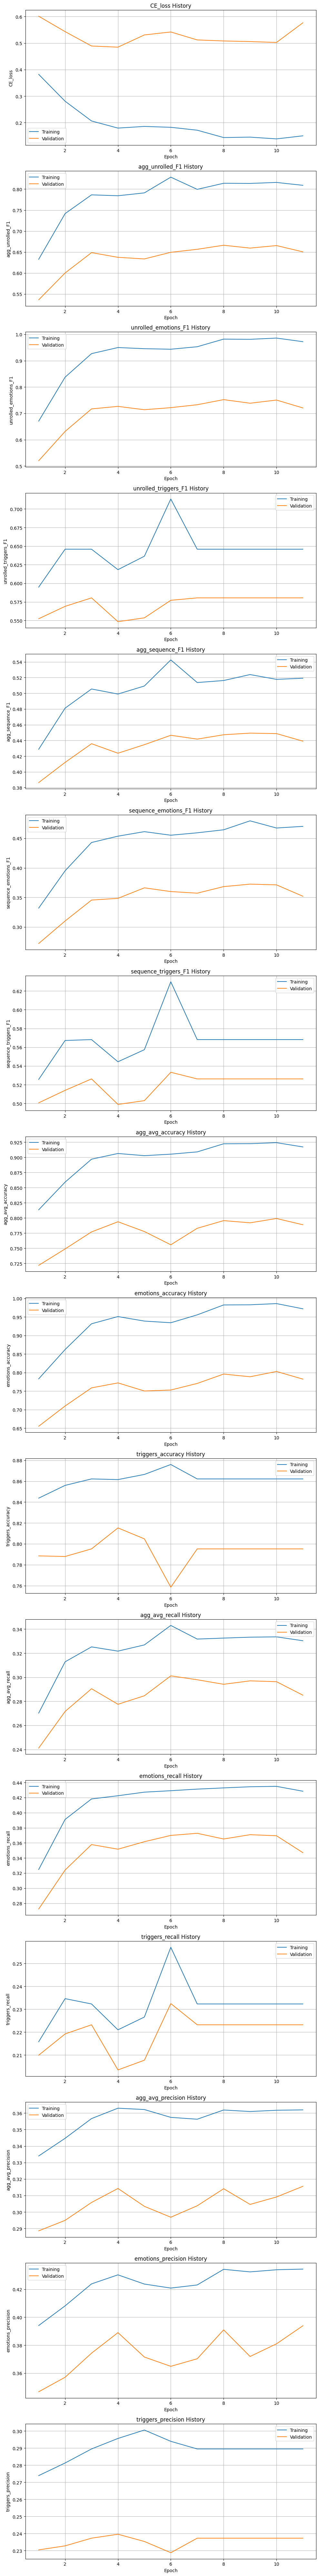

In [33]:
if FIT_FREEZED_BERTONE:
    plot_history(freezed_bertOne_history)
else:
    print('To show the training history of Freezed BERT base model  you should set the flag FIT_FREEZED_BERTONE=True')
    

##### Freezed BertOne Performance on the Test Set 

In [34]:
if RUN_FREEZED_BERTONE_PREDICT:
    freezed_bertOne.load_state_dict(torch.load(FREEZED_BERTONE_WEIGHTS_PATH))

    pred = freezed_bertOne.predict(data=test_dataloader_freezed, model_output_function_transformation=torch.argmax)
    
    freezed_bertOne_results_df = test_df.copy()
    freezed_bertOne_results_df['pred_emotions'] = [[IDX_TO_EMOTIONS[emotion] for emotion in utterance_emotions] for utterance_emotions in pred['emotions'].tolist()]
    freezed_bertOne_results_df['pred_triggers'] =  pred['triggers'].tolist()
    
    max_length = len(freezed_bertOne_results_df.iloc[0]['pred_emotions'])
    freezed_bertOne_results_df['padded_emotions'] = freezed_bertOne_results_df['emotions'].apply(lambda x: x + ['z_emotion'] * (max_length - len(x)))
    freezed_bertOne_results_df['padded_triggers'] = freezed_bertOne_results_df['triggers'].apply(lambda x: x + [2] * (max_length - len(x)))
    
    
    emotion_f1 = F1_Score(name='emotions_F1',
                          mode='macro',
                          num_classes=len(padded_emotions),
                          pred_transform=lambda x: x,
                          target_transform=lambda x: x,
                          classes_to_exclude=[7])     
    
    trigger_f1 = F1_Score(name='triggers_F1',
                          mode='macro',
                          num_classes=len(padded_triggers),
                          pred_transform=lambda x: x,
                          target_transform=lambda x: x,
                          classes_to_exclude=[2])     
    
    
    freezed_bertOne_unrolled_emotions_f1, freezed_bertOne_unrolled_triggers_f1 = compute_unrolled_f1(emotion_f1=emotion_f1, 
                                                                                                     trigger_f1=trigger_f1, 
                                                                                                     targets_emotions=freezed_bertOne_results_df['padded_emotions'],
                                                                                                     predictions_emotions=freezed_bertOne_results_df['pred_emotions'],
                                                                                                     targets_triggers=freezed_bertOne_results_df['padded_triggers'],
                                                                                                     predictions_triggers=freezed_bertOne_results_df['pred_triggers'],
                                                                                                     emotion_to_index=EMOTIONS_TO_IDX)
     
    freezed_bertOne_f1_per_dialogue_df = compute_f1_per_dialogues(emotion_f1=emotion_f1, 
                                                                  trigger_f1=trigger_f1, 
                                                                  targets_emotions=freezed_bertOne_results_df['padded_emotions'],
                                                                  predictions_emotions=freezed_bertOne_results_df['pred_emotions'],
                                                                  targets_triggers=freezed_bertOne_results_df['padded_triggers'],
                                                                  predictions_triggers=freezed_bertOne_results_df['pred_triggers'],
                                                                  emotion_to_index=EMOTIONS_TO_IDX)
    
    # Setting metric objects in none mode in order to compute the score for each class
    emotion_f1.mode='none'
    trigger_f1.mode='none'
    
    freezed_bertOne_emotions_f1_per_class, freezed_bertOne_triggers_f1_per_class = compute_unrolled_f1(emotion_f1=emotion_f1, 
                                                                                                       trigger_f1=trigger_f1, 
                                                                                                       targets_emotions=freezed_bertOne_results_df['padded_emotions'],
                                                                                                       predictions_emotions=freezed_bertOne_results_df['pred_emotions'],
                                                                                                       targets_triggers=freezed_bertOne_results_df['padded_triggers'],
                                                                                                       predictions_triggers=freezed_bertOne_results_df['pred_triggers'],
                                                                                                       emotion_to_index=EMOTIONS_TO_IDX)
     
    freezed_bertOne_results_df.drop(columns=['padded_emotions', 'padded_triggers'], inplace=True)
    freezed_bertOne_results_df['pred_emotions'] = freezed_bertOne_results_df.apply(lambda row: row['pred_emotions'][:len(row['emotions'])], axis=1)
    freezed_bertOne_results_df['pred_triggers'] = freezed_bertOne_results_df.apply(lambda row: row['pred_triggers'][:len(row['triggers'])], axis=1)
    
    
    
    
    freezed_bertOne_unrolled_and_sequence_f1_df = pd.DataFrame(data={'freezed_bertone_cls_scores':[freezed_bertOne_unrolled_emotions_f1, 
                                                                                                   freezed_bertOne_unrolled_triggers_f1, 
                                                                                                   freezed_bertOne_f1_per_dialogue_df["emotion_f1"].mean(),
                                                                                                   freezed_bertOne_f1_per_dialogue_df["trigger_f1"].mean()]},
                                                               index=['unrolled emotion F1 scores', 
                                                                      'unrolled trigger F1 scores', 
                                                                      'sequence emotion F1 score', 
                                                                      'sequence trigger F1 score'])            
            
    
    freezed_bertOne_emotions_f1_per_class_df = pd.DataFrame(freezed_bertOne_emotions_f1_per_class, index=EMOTIONS, columns=['freezed_bertOne_scores'])
    freezed_bertOne_triggers_f1_per_class_df = pd.DataFrame(freezed_bertOne_triggers_f1_per_class,columns=['freezed_bertOne_scores'] )
    
    freezed_bertOne_results_df['triggers'] = random_clf_results_df['triggers'].apply(lambda l: [int(x) for x in l])

    
    freezed_bertOne_results_df.index.name = 'index'
    freezed_bertOne_f1_per_dialogue_df.index.name = 'episode'
    freezed_bertOne_unrolled_and_sequence_f1_df.index.name = 'metrics'
    freezed_bertOne_emotions_f1_per_class_df.index.name = 'emotions'
    freezed_bertOne_triggers_f1_per_class_df.index.name = 'triggers'
    freezed_bertOne_f1_per_dialogue_df.columns = ['freezed_bertOne_'+ c_n for c_n in freezed_bertOne_f1_per_dialogue_df.columns]

    
    # Saving Freezed BertOne results
    freezed_bertOne_results_df.to_csv(FREEZED_BERTONE_PREDICTIONS_DF_PATH)
    freezed_bertOne_f1_per_dialogue_df.to_csv(FREEZED_BERTONE_F1_DIALOGUE_DF_PATH)
    freezed_bertOne_unrolled_and_sequence_f1_df.to_csv(FREEZED_BERTONE_UNROLLED_AND_SEQUENCE_F1_DF_PATH)
    freezed_bertOne_emotions_f1_per_class_df.to_csv(FREEZED_BERTONE_F1_PER_EMOTION_CLASSES_DF_PATH)
    freezed_bertOne_triggers_f1_per_class_df.to_csv(FREEZED_BERTONE_F1_PER_TRIGGER_CLASSES_DF_PATH)
   
else:
    # Loading Freezed bertOne results  
    freezed_bertOne_results_df = pd.read_csv(FREEZED_BERTONE_PREDICTIONS_DF_PATH, index_col=0)
    freezed_bertOne_f1_per_dialogue_df = pd.read_csv(FREEZED_BERTONE_F1_DIALOGUE_DF_PATH, index_col=0)
    freezed_bertOne_unrolled_and_sequence_f1_df = pd.read_csv(FREEZED_BERTONE_UNROLLED_AND_SEQUENCE_F1_DF_PATH, index_col=0)
    freezed_bertOne_emotions_f1_per_class_df = pd.read_csv(FREEZED_BERTONE_F1_PER_EMOTION_CLASSES_DF_PATH, index_col=0)
    freezed_bertOne_triggers_f1_per_class_df = pd.read_csv(FREEZED_BERTONE_F1_PER_TRIGGER_CLASSES_DF_PATH, index_col=0)
    
    
# Merging Freezed BertOne results to de file result dfs    
f1_per_dialogue_df = f1_per_dialogue_df.merge(freezed_bertOne_f1_per_dialogue_df, how='outer', left_index=True, right_index=True)
unrolled_and_sequence_f1_df = unrolled_and_sequence_f1_df.merge(freezed_bertOne_unrolled_and_sequence_f1_df, how='outer', left_index=True, right_index=True)
emotions_f1_per_class_df = emotions_f1_per_class_df.merge(freezed_bertOne_emotions_f1_per_class_df, how='outer', left_index=True, right_index=True)
triggers_f1_per_class_df = triggers_f1_per_class_df.merge(freezed_bertOne_triggers_f1_per_class_df, how='outer', left_index=True, right_index=True)


#### Full BertOne

##### Grid Search Full BertOne 

Once a good subset of hyperparameters is defined, a grid search is conducted to iterate over five seeds to determine whether to use the class weights defined above. Despite the class imbalance, the presence of class weights is not beneficial for the overall performance of the model, leading to a decrease of a few percentage points in almost every training configuration.

In [3]:
if RUN_FULL_BERTONE_GRID_SEARCH:
    
    #creating Wandb config params 
    if INTERACT_WITH_WANDB:
        wandb_params = {'project': 'Emotion-flip-reasoning',
                        'tags': ['Deep Learning', 'NLP'],
                        'entity': "nlp_course_project"}
    else:
        wandb_params = None

    hyperparameters_key_to_save = ['criterion', 'name']
    optimizers = [OptimizerWrapper(torch.optim.Adam, identifier=f'lr={2*(10**(-5))}', optimizer_partial_params={'lr':2*(10**(-5))})]

    # Defining single Head Criterion
    emotion_criterion = Criterion(name='emotion_cross_entropy',
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),
                                  reshape_loss_input_f=reshape_loss_input)

    trigger_criterion = Criterion(name='trigger_cross_entropy',
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),
                                  reshape_loss_input_f=reshape_loss_input)
    
    
    # Defining single Head Criterion that use class weights
    emotion_criterion_w_cw = Criterion(name='emotion_cross_entropy',
                                       loss_function=torch.nn.CrossEntropyLoss(reduction='none', weight=torch.tensor(emotion_weights, device=device)),
                                       reshape_loss_input_f=reshape_loss_input)

    trigger_criterion_w_cw = Criterion(name='trigger_cross_entropy',
                                       loss_function=torch.nn.CrossEntropyLoss(reduction='none', weight=torch.tensor(trigger_weights, device=device)),
                                       reshape_loss_input_f=reshape_loss_input)


    # Aggregate single head criteria into a multi-head criteria
    multi_head_criterion = MultiHeadCriterion(name='CE_loss',
                                              loss_functions={'emotions': emotion_criterion,
                                                              'triggers': trigger_criterion},
                                              loss_weights={'emotions':1, 
                                                            'triggers':1},
                                              reduction_function=torch.mean)

    
    # Aggregate single head criteria that use class weights into a multi-head criteria
    multi_head_criterion_w_cw = MultiHeadCriterion(name='CE_loss_w_cw',
                                                   loss_functions={'emotions': emotion_criterion_w_cw,
                                                                   'triggers': trigger_criterion_w_cw},
                                                   loss_weights={'emotions': 1, 
                                                                 'triggers': 1},
                                                   reduction_function=torch.mean)

    
    # List of the criteria to test
    criteria = [multi_head_criterion_w_cw, multi_head_criterion]


    # Early Stopper definition
    early_stopper = EarlyStopper(monitor='agg_unrolled_F1',
                                 patience=PATIENCE, 
                                 delta=DELTA, 
                                 mode='max',
                                 restore_weights=True)
    

    model_hyperparameters_to_test=[{'model_class': BertOne,
                                    'bert_model': bert_model,
                                    'n_emotions': len(padded_emotions),
                                    'n_triggers': len(padded_triggers),
                                    'cls_input_size': n_token_per_utterance * BERT_HIDDEN_DIM,
                                    'hidden_dim': 512,
                                    'freeze_bert_weights': False,
                                    'name': 'FullBertone'}]

    training_hyperparameters_to_test = [{'num_epochs': MAX_N_EPOCH,
                                         'optimizer': optimizer,
                                         'batch_size': BATCH_SIZE_FULL,
                                         'criterion': current_criterion,
                                         'early_stopper': early_stopper,
                                         'metrics': [unrolled_multi_head_f1, sentence_multi_head_f1, multi_head_accuracy, multi_head_recall, multi_head_precision],
                                         'interaction_with_wandb': INTERACT_WITH_WANDB,
                                         } for optimizer, current_criterion in itertools.product(optimizers, criteria)]


    dataLoaderBuilder = DataLoaderFromPipelineStrategy(logic=partial(my_logic))


    grid_search_train_validation(train_data=(train_df['utterances'], train_df[['emotions', 'triggers']]),
                                 val_data=(val_df['utterances'], val_df[['emotions', 'triggers']]),
                                 dataloader_builder=dataLoaderBuilder,
                                 shuffle=True,
                                 model_hyperparameters_to_test=model_hyperparameters_to_test,
                                 training_hyperparameters_to_test=training_hyperparameters_to_test,
                                 hyperparameters_key_to_save=hyperparameters_key_to_save,
                                 device=device,
                                 path_to_save_grid_search_results=FULL_BERTONE_GRID_SEARCH_RESULTS_PATH,
                                 seeds=SEEDS,
                                 save_loss_values=False,
                                 wandb_params=wandb_params)


100%|██████████| 2/2 [20:08:38<00:00, 36259.13s/it]


##### Visualizing grid search results for Freezed Bertone  

In [35]:
# Results of the single configurations
Full_grid_result_df = joblib.load(FULL_BERTONE_GRID_SEARCH_RESULTS_PATH)
Full_grid_result_df


,criterion,name,time,seed,train_loss,val_loss,agg_unrolled_F1_train,agg_unrolled_F1_val,unrolled_emotions_F1_train,unrolled_emotions_F1_val,unrolled_triggers_F1_train,unrolled_triggers_F1_val,agg_sequence_F1_train,agg_sequence_F1_val,sequence_emotions_F1_train,sequence_emotions_F1_val,sequence_triggers_F1_train,sequence_triggers_F1_val,agg_avg_accuracy_train,agg_avg_accuracy_val,emotions_accuracy_train,emotions_accuracy_val,triggers_accuracy_train,triggers_accuracy_val,agg_avg_recall_train,agg_avg_recall_val,emotions_recall_train,emotions_recall_val,triggers_recall_train,triggers_recall_val,agg_avg_precision_train,agg_avg_precision_val,emotions_precision_train,emotions_precision_val,triggers_precision_train,triggers_precision_val
0,CE_loss_w_cw,FullBertone,5188.309353,42,0.226014,0.638060,0.832369,0.631007,0.938792,0.703511,0.725945,0.558502,0.568809,0.440867,0.474314,0.359883,0.663304,0.521851,0.895713,0.717195,0.941166,0.751818,0.850260,0.682572,0.354367,0.308937,0.431020,0.372303,0.277714,0.245571,0.345600,0.287344,0.416957,0.352719,0.274244,0.221969
1,CE_loss_w_cw,FullBertone,7125.917514,69,0.178650,0.656044,0.857320,0.639544,0.953450,0.721283,0.761190,0.557804,0.592002,0.448175,0.482888,0.374108,0.701115,0.522242,0.911214,0.712831,0.960445,0.762584,0.861984,0.663078,0.362312,0.313390,0.433195,0.375188,0.291429,0.251592,0.350615,0.292591,0.421390,0.361859,0.279840,0.223324
2,CE_loss_w_cw,FullBertone,6471.662224,90,0.170134,0.660915,0.840642,0.624976,0.977979,0.759026,0.703306,0.490926,0.580004,0.430313,0.484166,0.379248,0.675841,0.481377,0.878555,0.663515,0.974948,0.785278,0.782161,0.541752,0.366129,0.312255,0.434857,0.375976,0.297400,0.248534,0.345351,0.298452,0.430453,0.380232,0.260249,0.216672
3,CE_loss_w_cw,FullBertone,4528.455828,1,0.242695,0.622781,0.793337,0.602733,0.901040,0.667847,0.685634,0.537619,0.549721,0.440970,0.455606,0.357212,0.643836,0.524727,0.848710,0.662496,0.910341,0.717195,0.787079,0.607797,0.356027,0.313670,0.427176,0.370007,0.284878,0.257333,0.330076,0.280221,0.403980,0.337032,0.256173,0.223409
4,CE_loss_w_cw,FullBertone,5272.348975,77,0.239457,0.719331,0.839288,0.661478,0.964848,0.742286,0.713728,0.580670,0.563381,0.452231,0.487375,0.366273,0.639387,0.538189,0.909949,0.753710,0.961122,0.779168,0.858777,0.728251,0.349334,0.304228,0.432177,0.364420,0.266490,0.244035,0.352962,0.306052,0.427254,0.384136,0.278671,0.227968
5,CE_loss,FullBertone,11430.282963,42,0.081267,0.531266,0.911099,0.680368,0.998952,0.795565,0.823246,0.565172,0.617074,0.457750,0.494049,0.394912,0.740099,0.520587,0.956275,0.771603,0.999145,0.832412,0.913406,0.710794,0.364893,0.308271,0.437277,0.376008,0.292509,0.240533,0.372219,0.312636,0.437265,0.402189,0.307173,0.223083
6,CE_loss,FullBertone,8920.878168,69,0.094862,0.470056,0.879977,0.669255,0.997732,0.772009,0.762222,0.566502,0.582408,0.447148,0.492230,0.384627,0.672585,0.509669,0.947580,0.785714,0.997755,0.814664,0.897406,0.756765,0.352897,0.298980,0.436888,0.370750,0.268907,0.227210,0.372800,0.309676,0.437119,0.393938,0.308481,0.225413
7,CE_loss,FullBertone,8953.741936,90,0.094385,0.495680,0.894167,0.674581,0.997508,0.780794,0.790826,0.568368,0.598725,0.456448,0.492066,0.384483,0.705384,0.528412,0.950093,0.771312,0.997185,0.818446,0.903000,0.724178,0.358882,0.305561,0.436829,0.372944,0.280936,0.238179,0.371426,0.310042,0.437080,0.395985,0.305771,0.224099
8,CE_loss,FullBertone,8245.754485,1,0.108700,0.503493,0.889372,0.669686,0.993703,0.767481,0.785042,0.571891,0.600885,0.462898,0.497212,0.390863,0.704559,0.534933,0.944142,0.764475,0.992695,0.800116,0.895588,0.728833,0.359931,0.309576,0.436688,0.380396,0.283174,0.238755,0.367304,0.302920,0.435555,0.380552,0.299053,0.225288
9,CE_loss,FullBertone,6155.850394,77,0.133145,0.488114,0.867613,0.670436,0.988304,0.762679,0.746922,0.578193,0.578844,0.460465,0.494125,0.382242,0.663563,0.538687,0.934164,0.760983,0.985924,0.793134,0.882403,0.728833,0.352697,0.304351,0.434792,0.366432,0.270603,0.242270,0.364617,0.311241,0.435076,0.395188,0.29

In [36]:
# Averaged results over the 5 seeds
Full_grid_result_df['criterion'] = Full_grid_result_df['criterion'].apply(lambda x: x.name)
column_to_consider = [column_name for column_name in Full_grid_result_df.keys() if column_name not in ['criterion', 'name', 'seed']]
statistics_df = Full_grid_result_df.groupby('criterion')[column_to_consider].agg(['mean', 'std'])

pd.set_option('display.max_columns', None) 
statistics_df


time              train_loss            val_loss  \
                     mean          std       mean       std      mean   
criterion                                                               
CE_loss       8741.301589  1886.671957   0.102472  0.019702  0.497722   
CE_loss_w_cw  5717.338779  1054.090680   0.211390  0.034480  0.659426   

                       agg_unrolled_F1_train           agg_unrolled_F1_val  \
                   std                  mean       std                mean   
criterion                                                                    
CE_loss       0.022474              0.888446  0.016221            0.672865   
CE_loss_w_cw  0.036748              0.832591  0.023781            0.631948   

                       unrolled_emotions_F1_train            \
                   std                       mean       std   
criterion                                                     
CE_loss       0.004698                   0.995240  0.004347   
CE_loss_w_cw  0.021405                   0.947222  0.029577   

             unrolled_emotions_F1_val           unrolled_triggers_F1_train  \
                                 mean       std                       mean   
criterion                                                                    
CE_loss                      0.775706  0.012954                   0.781651   
CE_loss_w_cw                 0.718791  0.035376                   0.717960   

                       unrolled_triggers_F1_val            \
                   std                     mean       std   
criterion                                                   
CE_loss       0.029195                 0.570025  0.005218   
CE_loss_w_cw  0.028329                 0.545104  0.033901   

             agg_sequence_F1_train           agg_sequence_F1_val            \
                              mean       std                mean       std   
criterion                                                                    
CE_loss                   0.595587  0.015440            0.456942  0.006015   
CE_loss_w_cw              0.570783  0.016105            0.442511  0.008373   

             sequence_emotions_F1_train           sequence_emotions_F1_val  \
                                   mean       std                     mean   
criterion                                                                    
CE_loss                        0.493936  0.002073                 0.387426   
CE_loss_w_cw                   0.476870  0.012831                 0.367345   

                       sequence_triggers_F1_train            \
                   std                       mean       std   
criterion                                                     
CE_loss       0.005273                   0.697238  0.030409   
CE_loss_w_cw  0.009313                   0.664697  0.025141   

             sequence_triggers_F1_val           agg_avg_accuracy_train  \
                                 mean       std                   mean   
criterion                                                                
CE_loss                      0.526458  0.011635               0.946451   
CE_loss_w_cw                 0.517677  0.021368               0.888828   

                       agg_avg_accuracy_val           emotions_accuracy_train  \
                   std                 mean       std                    mean   
criterion                                                                       
CE_loss       0.008176             0.770818  0.009483                0.994541   
CE_loss_w_cw  0.026027             0.701949  0.038935                0.949604   

                       emotions_accuracy_val            \
                   std                  mean       std   
criterion                                                
CE_loss       0.005389              0.811754  0.015509   
CE_loss_w_cw  0.025026              0.759209  0.026968   

             triggers_accuracy_train           triggers_accuracy_val  \
             

##### Creation of Full BertOne for Single Execution

In [37]:
full_bertOne = BertOne(bert_model=bert_model,
                       n_emotions=len(padded_emotions),
                       n_triggers=len(padded_triggers),
                       cls_input_size=n_token_per_utterance * BERT_HIDDEN_DIM,
                       hidden_dim=512,
                       freeze_bert_weights=False,
                       name='FullBertOne').to(device)


##### Summary of the Model

In [38]:
full_bertOne.summary(input_data_full, verbose=True)


--------------------------------------------------------------------
             Layer (type)               Output Shape         Param #
              Embedding-1              [2, 380, 768]      23,440,896
              Embedding-2              [2, 380, 768]           1,536
              Embedding-3              [2, 380, 768]         393,216
              LayerNorm-4              [2, 380, 768]           1,536
                Dropout-5              [2, 380, 768]               0
         BertEmbeddings-6              [2, 380, 768]               0
                 Linear-7              [2, 380, 768]         590,592
                 Linear-8              [2, 380, 768]         590,592
                 Linear-9              [2, 380, 768]         590,592
               Dropout-10          [2, 12, 380, 380]               0
     BertSelfAttention-11           [[-1, 380, 768]]               0
                Linear-12              [2, 380, 768]         590,592
               Dropout-13         

##### Fitting the Single Full BertOne with Best Hyperparameters

In [40]:
if FIT_FULL_BERTONE:
    
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    
    
    # Losses definitions and combination    
    emotion_criterion = Criterion(name='emotion_cross_entropy', 
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),
                                  reshape_loss_input_f=reshape_loss_input)
    
    trigger_criterion = Criterion(name='trigger_cross_entropy', 
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),                                
                                  reshape_loss_input_f=reshape_loss_input)

    
    multi_head_criterion = MultiHeadCriterion(name='agg_CE_loss',
                                              loss_functions={'emotions': emotion_criterion, 
                                                              'triggers': trigger_criterion},
                                              loss_weights={'emotions': 1, 
                                                            'triggers': 1},
                                              reduction_function=torch.mean)
    
    # Early Stopper definition
    early_stopper = EarlyStopper(monitor='agg_unrolled_F1',
                                 patience=PATIENCE, 
                                 delta=DELTA, 
                                 mode='max',
                                 restore_weights=True)
    
        
    # Optimizer definition
    optimizer = OptimizerWrapper(optimizer_constructor=torch.optim.Adam,
                                 identifier=f'lr={2*(10**(-5))}', 
                                 optimizer_partial_params={'lr': 2*(10**(-5))})  
        
    
    
    if INTERACT_WITH_WANDB:
        wandb_params = {'project': 'Emotion-flip-reasoning',
                        'tags': ['Deep Learning', 'NLP'],
                        'entity': "nlp_course_project"}
        
        wandb.init(**wandb_params)
        
    full_bertOne_history = full_bertOne.fit(train_loader=train_dataloader_full,
                                            val_loader=val_dataloader_full,
                                            criterion=multi_head_criterion,
                                            metrics=[unrolled_multi_head_f1, sentence_multi_head_f1, multi_head_accuracy, multi_head_recall, multi_head_precision],
                                            optimizer=optimizer,
                                            early_stopper=early_stopper,
                                            num_epochs=MAX_N_EPOCH,
                                            verbose=2,
                                            interaction_with_wandb=INTERACT_WITH_WANDB,
                                            interaction_function_with_wandb=send_a_predicted_sample_to_wandb)
        
    torch.save(full_bertOne.state_dict(), FULL_BERTONE_WEIGHTS_PATH)

else:
    full_bertOne.load_state_dict(torch.load(FULL_BERTONE_WEIGHTS_PATH))
    full_bertOne_history = None


wandb: Currently logged in as: murgiariccardo96 (nlp_course_project). Use `wandb login --relogin` to force relogin


Epoch 1/100                                           Time: 897.1897s
Metric/Loss                   Training                 Validation               
----------------------------------------------------------------------
Agg_ce_loss                   0.3968264664             0.6240684945             
Unrolled_emotions_f1          0.6830398208             0.5045219960             
Unrolled_triggers_f1          0.6038035666             0.5725544708             
Agg_unrolled_f1               0.6434216937             0.5385382334             
Sequence_emotions_f1          0.3145840054             0.2456043098             
Sequence_triggers_f1          0.5360789226             0.5168275096             
Agg_sequence_f1               0.4253314640             0.3812159097             
Emotions_accuracy             0.7565034566             0.6322374164             
Triggers_accuracy             0.8421709073             0.7934244981             
Agg_avg_accuracy              0.7993371820       

##### Visualizing training history  

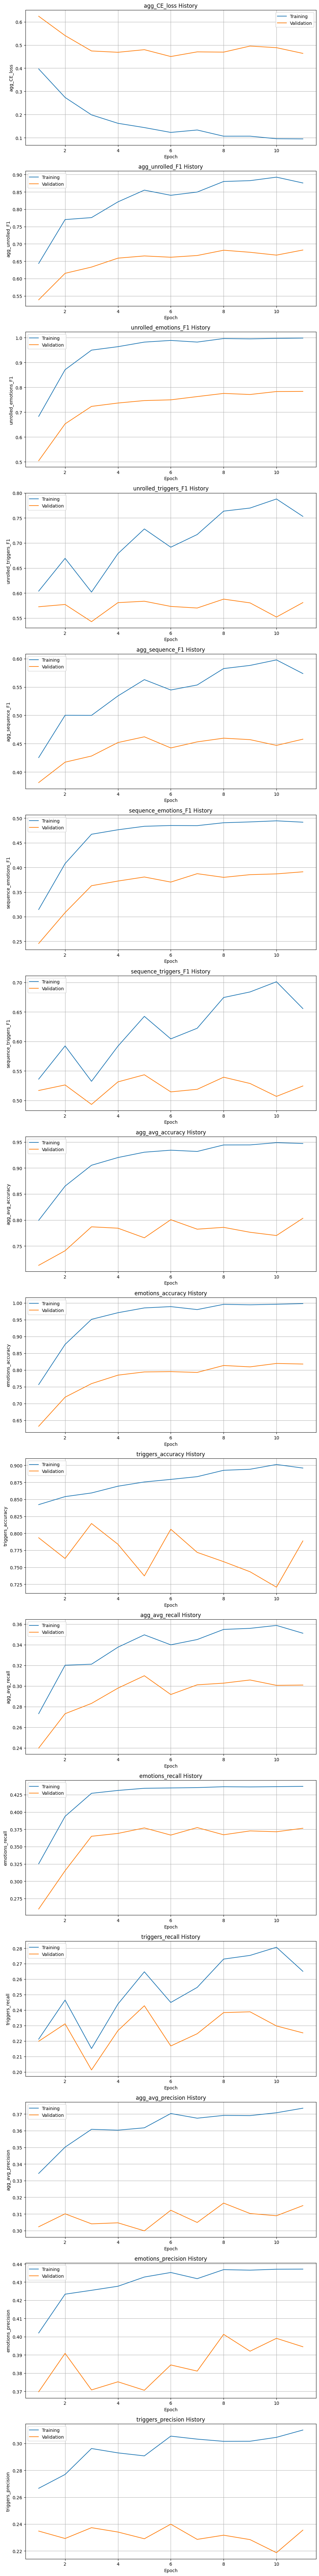

In [41]:
if FIT_FULL_BERTONE:
    plot_history(full_bertOne_history)
else:
    print('To show the training history of Full BERT base model you should set the flag FIT_FULL_BERTONE=True')
    

##### Full BertOne Performance on the Test Set 

In [39]:
if RUN_FULL_BERTONE_PREDICT:
    full_bertOne.load_state_dict(torch.load(FULL_BERTONE_WEIGHTS_PATH))

    pred = full_bertOne.predict(data=test_dataloader_full, model_output_function_transformation=torch.argmax)
    
    full_bertOne_results_df = test_df.copy()
    full_bertOne_results_df['pred_emotions'] = [[IDX_TO_EMOTIONS[emotion] for emotion in utterance_emotions] for utterance_emotions in pred['emotions'].tolist()]
    full_bertOne_results_df['pred_triggers'] =  pred['triggers'].tolist()
    
    max_length = len(full_bertOne_results_df.iloc[0]['pred_emotions'])
    full_bertOne_results_df['padded_emotions'] = full_bertOne_results_df['emotions'].apply(lambda x: x + ['z_emotion'] * (max_length - len(x)))
    full_bertOne_results_df['padded_triggers'] = full_bertOne_results_df['triggers'].apply(lambda x: x + [2] * (max_length - len(x)))
    

    emotion_f1 = F1_Score(name='emotions_F1',
                          mode='macro',
                          num_classes=len(padded_emotions),
                          pred_transform=lambda x: x,
                          target_transform=lambda x: x,
                          classes_to_exclude=[7])     
    
    trigger_f1 = F1_Score(name='triggers_F1',
                          mode='macro',
                          num_classes=len(padded_triggers),
                          pred_transform=lambda x: x,
                          target_transform=lambda x: x,
                          classes_to_exclude=[2])     
    
    
    full_bertOne_unrolled_emotions_f1, full_bertOne_unrolled_triggers_f1 = compute_unrolled_f1(emotion_f1=emotion_f1, 
                                                                                               trigger_f1=trigger_f1, 
                                                                                               targets_emotions=full_bertOne_results_df['padded_emotions'],
                                                                                               predictions_emotions=full_bertOne_results_df['pred_emotions'],
                                                                                               targets_triggers=full_bertOne_results_df['padded_triggers'],
                                                                                               predictions_triggers=full_bertOne_results_df['pred_triggers'],
                                                                                               emotion_to_index=EMOTIONS_TO_IDX)
    
    full_bertOne_f1_per_dialogue_df = compute_f1_per_dialogues(emotion_f1=emotion_f1, 
                                                               trigger_f1=trigger_f1, 
                                                               targets_emotions=full_bertOne_results_df['padded_emotions'],
                                                               predictions_emotions=full_bertOne_results_df['pred_emotions'],
                                                               targets_triggers=full_bertOne_results_df['padded_triggers'],
                                                               predictions_triggers=full_bertOne_results_df['pred_triggers'],
                                                               emotion_to_index=EMOTIONS_TO_IDX)
    
    # Setting metric objects in none mode in order to compute the score for each class
    emotion_f1.mode='none'
    trigger_f1.mode='none'
    
    full_bertOne_emotions_f1_per_class, full_bertOne_triggers_f1_per_class = compute_unrolled_f1(emotion_f1=emotion_f1, 
                                                                                                 trigger_f1=trigger_f1, 
                                                                                                 targets_emotions=full_bertOne_results_df['padded_emotions'],
                                                                                                 predictions_emotions=full_bertOne_results_df['pred_emotions'],
                                                                                                 targets_triggers=full_bertOne_results_df['padded_triggers'],
                                                                                                 predictions_triggers=full_bertOne_results_df['pred_triggers'],
                                                                                                 emotion_to_index=EMOTIONS_TO_IDX)
     
     
    full_bertOne_results_df.drop(columns=['padded_emotions', 'padded_triggers'], inplace=True)
    full_bertOne_results_df['pred_emotions'] = full_bertOne_results_df.apply(lambda row: row['pred_emotions'][:len(row['emotions'])], axis=1)
    full_bertOne_results_df['pred_triggers'] = full_bertOne_results_df.apply(lambda row: row['pred_triggers'][:len(row['triggers'])], axis=1)

    
    full_bertOne_unrolled_and_sequence_f1_df = pd.DataFrame(data={'full_bertone_cls_scores':[full_bertOne_unrolled_emotions_f1, 
                                                                                             full_bertOne_unrolled_triggers_f1, 
                                                                                             full_bertOne_f1_per_dialogue_df["emotion_f1"].mean(),
                                                                                             full_bertOne_f1_per_dialogue_df["trigger_f1"].mean()]},
                                                            index=['unrolled emotion F1 scores', 
                                                                   'unrolled trigger F1 scores', 
                                                                   'sequence emotion F1 score', 
                                                                   'sequence trigger F1 score'])            
     
    
    full_bertOne_emotions_f1_per_class_df = pd.DataFrame(full_bertOne_emotions_f1_per_class, index=EMOTIONS, columns=['full_bertOne_scores'])
    full_bertOne_triggers_f1_per_class_df = pd.DataFrame(full_bertOne_triggers_f1_per_class,columns=['full_bertOne_scores'] )
    
    full_bertOne_results_df['triggers'] = random_clf_results_df['triggers'].apply(lambda l: [int(x) for x in l])

    
    full_bertOne_results_df.index.name = 'index'
    full_bertOne_f1_per_dialogue_df.index.name = 'episode'
    full_bertOne_unrolled_and_sequence_f1_df.index.name = 'metrics'
    full_bertOne_emotions_f1_per_class_df.index.name = 'emotions'
    full_bertOne_triggers_f1_per_class_df.index.name = 'triggers'
    full_bertOne_f1_per_dialogue_df.columns = ['full_bertOne_'+ c_n for c_n in full_bertOne_f1_per_dialogue_df.columns]
    
     # Saving Full bertOne results  
    full_bertOne_results_df.to_csv(FULL_BERTONE_PREDICTIONS_DF_PATH)
    full_bertOne_f1_per_dialogue_df.to_csv(FULL_BERTONE_F1_DIALOGUE_DF_PATH)
    full_bertOne_unrolled_and_sequence_f1_df.to_csv(FULL_BERTONE_UNROLLED_AND_SEQUENCE_F1_DF_PATH)
    full_bertOne_emotions_f1_per_class_df.to_csv(FULL_BERTONE_F1_PER_EMOTION_CLASSES_DF_PATH)
    full_bertOne_triggers_f1_per_class_df.to_csv(FULL_BERTONE_F1_PER_TRIGGER_CLASSES_DF_PATH)

else:
    # Loading Full bertOne results  
    full_bertOne_results_df = pd.read_csv(FULL_BERTONE_PREDICTIONS_DF_PATH, index_col=0)
    full_bertOne_f1_per_dialogue_df = pd.read_csv(FULL_BERTONE_F1_DIALOGUE_DF_PATH, index_col=0)
    full_bertOne_unrolled_and_sequence_f1_df = pd.read_csv(FULL_BERTONE_UNROLLED_AND_SEQUENCE_F1_DF_PATH, index_col=0)
    full_bertOne_emotions_f1_per_class_df = pd.read_csv(FULL_BERTONE_F1_PER_EMOTION_CLASSES_DF_PATH, index_col=0)
    full_bertOne_triggers_f1_per_class_df = pd.read_csv(FULL_BERTONE_F1_PER_TRIGGER_CLASSES_DF_PATH, index_col=0)
    
    
# Merging Full BertOne results to de file result dfs    
f1_per_dialogue_df = f1_per_dialogue_df.merge(full_bertOne_f1_per_dialogue_df, how='outer', left_index=True, right_index=True)
unrolled_and_sequence_f1_df = unrolled_and_sequence_f1_df.merge(full_bertOne_unrolled_and_sequence_f1_df, how='outer', left_index=True, right_index=True)
emotions_f1_per_class_df = emotions_f1_per_class_df.merge(full_bertOne_emotions_f1_per_class_df, how='outer', left_index=True, right_index=True)
triggers_f1_per_class_df = triggers_f1_per_class_df.merge(full_bertOne_triggers_f1_per_class_df, how='outer', left_index=True, right_index=True)


## Models Results and Error Analysis

### Confusion Matrices

As expected, in the case of the random classifiers, the values of the confusion matrices are spread and distributed according to the class distributions already observed. Also the majority classifier behaves as expected, assigning a single value for each class; this property allows the majority to develop a strong ability to detect True Negative triggers.

The confusion matrices of Bert Freezed and Bert Full have a very similar configuration, particularly:

- Emotions: All the emotions are usually correctly classified. However, we can observe occasional difficulty of the models in distinguishing between emotions that might also be confused by a human reader. For example, there are misclassifications of joy, which is sometimes interpreted as "surprise" or "anger". 
- Triggers: Bert Full shows a much higher ability in predicting True Negative values. On the other hand, Bert Freezed slightly performs better with True Positive values.


Confusion matrices of the models


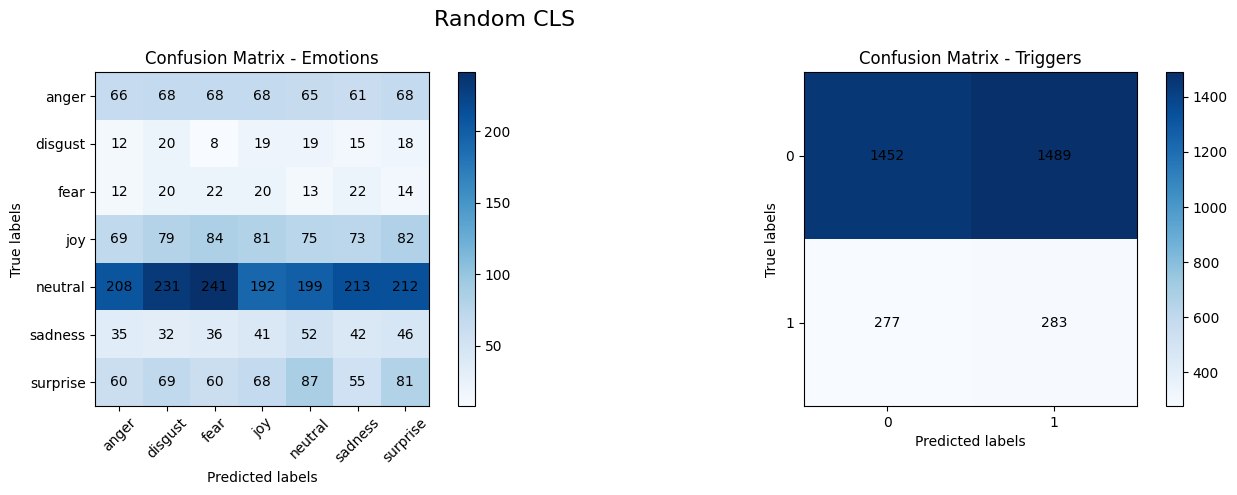

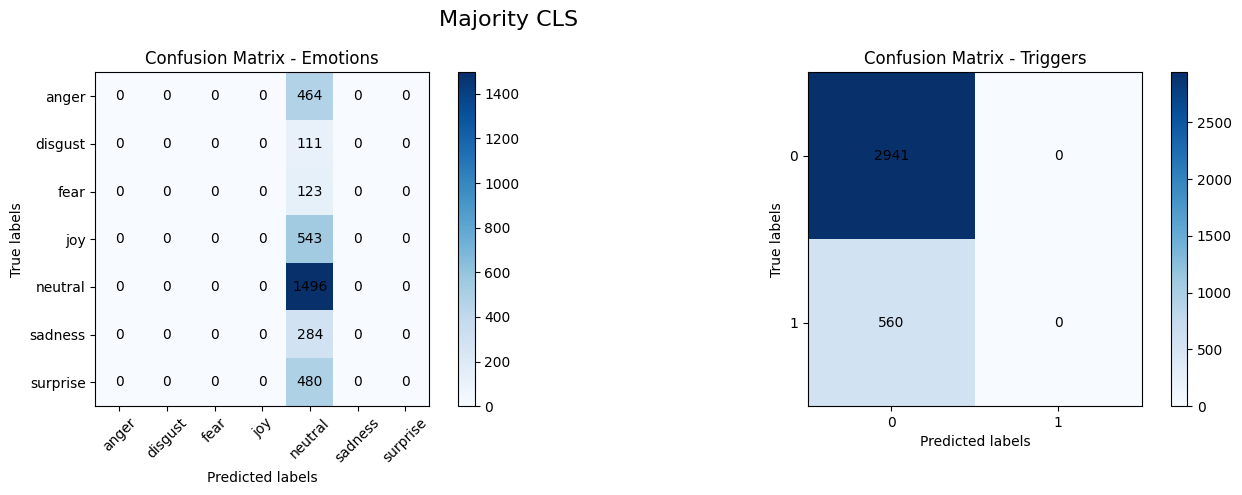

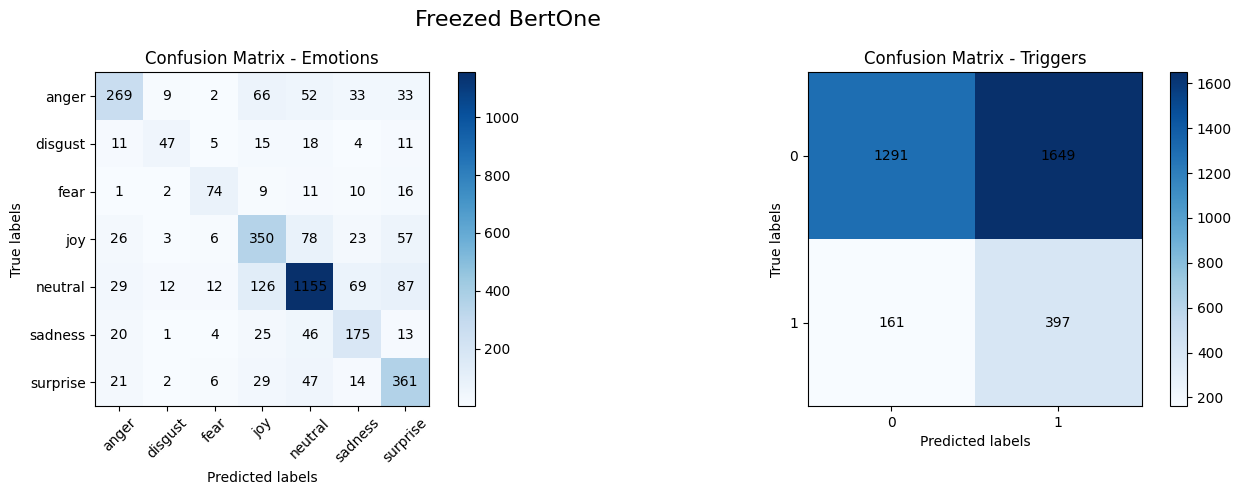

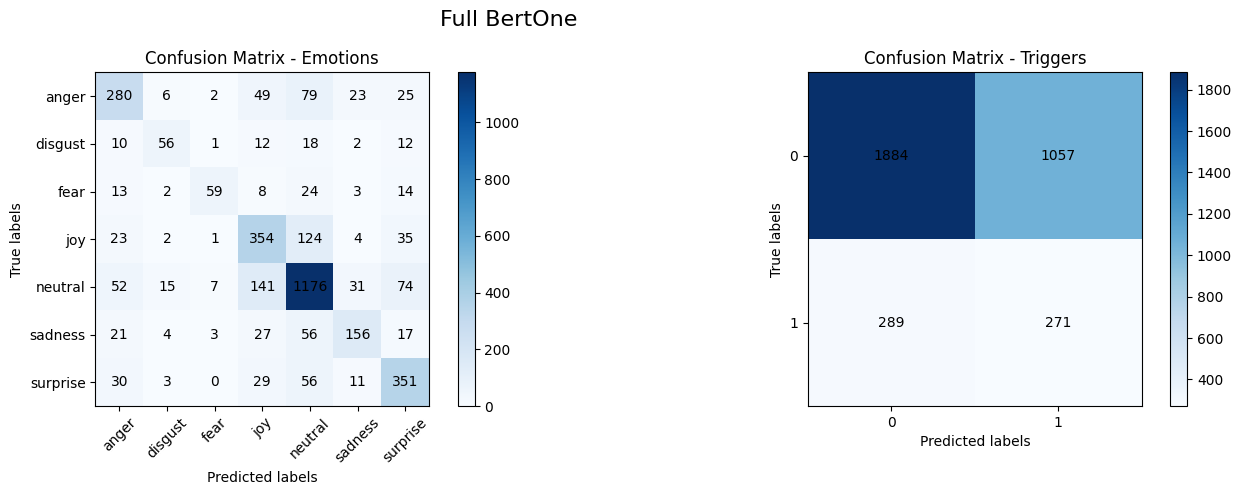

In [40]:
print('Confusion matrices of the models')
plot_confusion_matrix(target_emotions=random_clf_results_df['emotions'], 
                      pred_emotions=random_clf_results_df['pred_emotions'],
                      emotion_to_index_map=EMOTIONS_TO_IDX,
                      target_triggers=random_clf_results_df['triggers'], 
                      pred_triggers=random_clf_results_df['pred_triggers'],
                      title='Random CLS')

plot_confusion_matrix(target_emotions=majority_clf_results_df['emotions'], 
                      pred_emotions=majority_clf_results_df['pred_emotions'],
                      emotion_to_index_map=EMOTIONS_TO_IDX,
                      target_triggers=majority_clf_results_df['triggers'], 
                      pred_triggers=majority_clf_results_df['pred_triggers'],
                      title='Majority CLS')

plot_confusion_matrix(target_emotions=freezed_bertOne_results_df['emotions'], 
                      pred_emotions=freezed_bertOne_results_df['pred_emotions'],
                      emotion_to_index_map=EMOTIONS_TO_IDX,
                      target_triggers=freezed_bertOne_results_df['triggers'], 
                      pred_triggers=freezed_bertOne_results_df['pred_triggers'],
                      title='Freezed BertOne')

plot_confusion_matrix(target_emotions=full_bertOne_results_df['emotions'], 
                      pred_emotions=full_bertOne_results_df['pred_emotions'],
                      emotion_to_index_map=EMOTIONS_TO_IDX,
                      target_triggers=full_bertOne_results_df['triggers'], 
                      pred_triggers=full_bertOne_results_df['pred_triggers'],
                      title='Full BertOne')


### F1 Score Performance

The F1 scores are computed and displayed in two variants:
- Unrolled sequence F1: the score is computed on list of flattened utterances and then averaged.
- Sequence F1: the score is computed for each dialogue and averaged. 

The random and majority classifiers achieve poor results in terms of emotion classification, especially due to the number of possible values and their distribution, particularly evident in the case of sequence F1. However, they achieve higher results when dealing with trigger classification, with both reaching around an F1 score of $0.40$-$0.45$. 

Both Bert Freezed and Bert Full outperform the random and majority classifiers in every metric. The Bert-based models are very similar in terms of performance, with slight differences: Bert Freezed seems to be slightly better at predicting "anger", "fear" and "neutral" emotions, while Bert Full does better in detecting "disgust", "sadness" and "surprise". On the other hand, as already observed in the confusion matrices, Bert Full is much better at detecting when a trigger DOES NOT occur.

Overall, we can consider the results of Full Bert to be slightly better than Freezed Bert's. 

In [41]:
print('Comparison of Unrolled and Sequence F1 results for our models:')
display(unrolled_and_sequence_f1_df)
print('Unrolled F1 results on the different classes for our models:')
display(emotions_f1_per_class_df)
display(triggers_f1_per_class_df)
print('F1 results for each dialogue for our models:')
display(f1_per_dialogue_df)


Comparison of Unrolled and Sequence F1 results for our models:


,random_cls_scores,majority_cls_scores,freezed_bertone_cls_scores,full_bertone_cls_scores
metrics,,,,
sequence emotion F1 score,0.091966,0.174864,0.562747,0.566669
sequence trigger F1 score,0.411183,0.485011,0.431064,0.482464
unrolled emotion F1 scores,0.128800,0.085537,0.633179,0.640093
unrolled trigger F1 scores,0.432276,0.456535,0.446217,0.511939


Unrolled F1 results on the different classes for our models:


,random_scores,majority_scores,freezed_bertOne_scores,full_bertOne_scores
emotions,,,,
anger,0.142549,0.000000,0.639715,0.627100
disgust,0.063492,0.000000,0.502674,0.562814
fear,0.068536,0.000000,0.637931,0.602041
joy,0.156977,0.000000,0.601892,0.608770
neutral,0.198405,0.598759,0.795729,0.776494
sadness,0.109804,0.000000,0.571895,0.607004
surprise,0.161838,0.000000,0.682420,0.696429


,random_scores,majority_scores,freezed_bertOne_scores,full_bertOne_scores
triggers,,,,
0,0.621842,0.91307,0.587753,0.736801
1,0.242710,0.00000,0.304682,0.287076


F1 results for each dialogue for our models:


,random_emotion_f1,random_trigger_f1,majority_emotion_f1,majority_trigger_f1,freezed_bertOne_emotion_f1,freezed_bertOne_trigger_f1,full_bertOne_emotion_f1,full_bertOne_trigger_f1
episode,,,,,,,,
utterance_1,0.000000,0.222222,0.461538,0.461538,0.636364,0.533333,0.636364,0.416667
utterance_1016,0.081633,0.285714,0.030303,1.000000,0.688889,0.285714,0.352381,0.333333
utterance_1020,0.200000,0.333333,0.095238,1.000000,0.300000,0.142857,0.392857,0.400000
utterance_1021,0.200000,0.300000,0.148148,0.461538,0.300000,0.285714,0.392857,0.650000
utterance_1028,0.114286,0.272727,0.080000,0.483871,0.440476,0.287449,0.455988,0.500000
...,...,...,...,...,...,...,...,...
utterance_960,0.000000,1.000000,0.166667,0.400000,1.000000,0.666667,1.000000,0.666667
utterance_972,0.000000,0.363636,0.111111,1.000000,1.000000,0.300000,0.700000,0.300000
utterance_975,0.000000,0.000000,0.250000,0.250000,0.333333,1.000000,0.555556,0.666667


### Prediction Examples and Observations


In this section, we provide examples that illustrate what we have discussed in the earlier sections of this error analysis. We focus on why certain emotions are simpler to classify, the main difficulties of the models, and the most plausible reasons for these occurrences. We also delve into why the Bert-based models struggle to classify triggers (obtaining a lower F1 despite the lower number of labels per class) and highlight cases in which they perform well.

After collecting a good number of observations, we summarize the most interesting ones:
- The mistakes and misclassifications of emotions might be caused by several factors. We hypothesize that the spectrum of emotions we are trying to classify extends more over a range of negative emotions rather than positive ones, adding complexity to the task. For example, we need to classify disgust, fear, sadness, and anger (4 negative emotions) and only joy and surprise as positive emotions. However, it's worth noting that surprise can also be negative depending on the context.
- The simplest emotions to classify are "neutral," due to its high occurrence, "surprise," which is usually used in conjunction with exuberant punctuation (e.g., "!!!"), and anger, also used sometimes with unusual punctuation. This could mean that particular punctuation helps the model to narrow down the classification field, while emotions more closely related to body expressiveness, such as "disgust" or "sadness," are more difficult to detect.
- Some words, typically associated with positive (negative) contexts, may lead to misclassification if ironically used in a negative (positive) context.
- The mistakes in detecting a positive trigger may be due to the chunking step of the model pipeline. Despite the use of special tokens $[CLS]$ and $[SEP]$, which indicate the beginning of each dialogue and the separation between utterances, the chunking process splits the dialogues into several parts, resulting in a loss of context for the model.

Some of these observations are displayed in the following examples.

In [42]:
# lists to facilitate printing of results
clf_results_df_list = [random_clf_results_df, majority_clf_results_df, freezed_bertOne_results_df, full_bertOne_results_df]
model_names = ["Random classifier", "Majority classifier", "Bert-Freezed", "Bert-Full"]
metric_names = [("random_emotion_f1", "random_trigger_f1"), ("majority_emotion_f1", "majority_trigger_f1"), ("freezed_bertOne_emotion_f1", "freezed_bertOne_trigger_f1"), ("full_bertOne_emotion_f1", "full_bertOne_trigger_f1")]


In the example below, as in many other dialogues, we can observe how the majority classifier achieves a higher F1 score in dialogues with none to zero positive triggers. On the other hand, the Bert models tend to assign a high number of triggers, resulting in a lower F1 score, mostly in long dialogues. 

In [47]:
utterance = "utterance_1016"

for i, result_df in enumerate(clf_results_df_list):
    print(f"{model_names[i]}")
    emotion_metric = f1_per_dialogue_df.loc[utterance][metric_names[i][0]]
    trigger_metric = f1_per_dialogue_df.loc[utterance][metric_names[i][1]]
    print(f"Emotion F1 score: {emotion_metric} \nTrigger F1 Score: {trigger_metric}")
    display_dialogue(dataframe=result_df, utterance_id=utterance, verbose=False)
    

Random classifier
Emotion F1 score: 0.08163265306122448 
Trigger F1 Score: 0.2857142857142857


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Joey,surprise,The stripper stole the ring!! The stripper sto...,0,fear,0
1,Chandler,surprise,What?,0,sadness,1
2,Joey,surprise,The ring is gone!,0,anger,1
3,Chandler,disgust,Ugh.,0,joy,1
4,Chandler,neutral,"Just a sec, give me a minute to wake up for th...",0,anger,1
5,Chandler,joy,You lost the ring!,0,fear,0
6,Chandler,anger,You're the worst best man ever!,0,anger,0
7,Joey,anger,"Dude, this isn't funny!",0,anger,1
8,Joey,fear,What am I gonna do?!,0,disgust,1
9,Joey,joy,"I go to bed last night, everything's cool!",0,anger,0



Majority classifier
Emotion F1 score: 0.030303030303030304 
Trigger F1 Score: 1.0


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Joey,surprise,The stripper stole the ring!! The stripper sto...,0,neutral,0
1,Chandler,surprise,What?,0,neutral,0
2,Joey,surprise,The ring is gone!,0,neutral,0
3,Chandler,disgust,Ugh.,0,neutral,0
4,Chandler,neutral,"Just a sec, give me a minute to wake up for th...",0,neutral,0
5,Chandler,joy,You lost the ring!,0,neutral,0
6,Chandler,anger,You're the worst best man ever!,0,neutral,0
7,Joey,anger,"Dude, this isn't funny!",0,neutral,0
8,Joey,fear,What am I gonna do?!,0,neutral,0
9,Joey,joy,"I go to bed last night, everything's cool!",0,neutral,0



Bert-Freezed
Emotion F1 score: 0.519047619047619 
Trigger F1 Score: 0.2857142857142857


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Joey,surprise,The stripper stole the ring!! The stripper sto...,0,surprise,1
1,Chandler,surprise,What?,0,surprise,0
2,Joey,surprise,The ring is gone!,0,sadness,1
3,Chandler,disgust,Ugh.,0,neutral,0
4,Chandler,neutral,"Just a sec, give me a minute to wake up for th...",0,neutral,0
5,Chandler,joy,You lost the ring!,0,sadness,0
6,Chandler,anger,You're the worst best man ever!,0,joy,1
7,Joey,anger,"Dude, this isn't funny!",0,anger,1
8,Joey,fear,What am I gonna do?!,0,fear,1
9,Joey,joy,"I go to bed last night, everything's cool!",0,joy,1



Bert-Full
Emotion F1 score: 0.3523809523809524 
Trigger F1 Score: 0.3333333333333333


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Joey,surprise,The stripper stole the ring!! The stripper sto...,0,surprise,1
1,Chandler,surprise,What?,0,surprise,0
2,Joey,surprise,The ring is gone!,0,sadness,1
3,Chandler,disgust,Ugh.,0,neutral,0
4,Chandler,neutral,"Just a sec, give me a minute to wake up for th...",0,neutral,0
5,Chandler,joy,You lost the ring!,0,anger,1
6,Chandler,anger,You're the worst best man ever!,0,joy,0
7,Joey,anger,"Dude, this isn't funny!",0,anger,1
8,Joey,fear,What am I gonna do?!,0,disgust,1
9,Joey,joy,"I go to bed last night, everything's cool!",0,joy,0


On the other hand, Bert-based models have an advantage in short dialogues, where the probability of making mistakes is lower, as shown in the example below:

In [48]:
utterance = "utterance_975"

for i, result_df in enumerate(clf_results_df_list):
    print(f"{model_names[i]}")
    emotion_metric = f1_per_dialogue_df.loc[utterance][metric_names[i][0]]
    trigger_metric = f1_per_dialogue_df.loc[utterance][metric_names[i][1]]
    print(f"Emotion F1 score: {emotion_metric} \nTrigger F1 Score: {trigger_metric}")
    display_dialogue(dataframe=result_df, utterance_id=utterance, verbose=False)
    

Random classifier
Emotion F1 score: 0.0 
Trigger F1 Score: 0.0


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Phoebe,surprise,Oh my God! That guy at the counter is totally ...,1,sadness,0
1,Monica,surprise,"Really? My God, he's really cute.",1,joy,0
2,Phoebe,neutral,Go for it.,0,fear,1



Majority classifier
Emotion F1 score: 0.25 
Trigger F1 Score: 0.25


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Phoebe,surprise,Oh my God! That guy at the counter is totally ...,1,neutral,0
1,Monica,surprise,"Really? My God, he's really cute.",1,neutral,0
2,Phoebe,neutral,Go for it.,0,neutral,0



Bert-Freezed
Emotion F1 score: 1.0 
Trigger F1 Score: 0.6666666666666666


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Phoebe,surprise,Oh my God! That guy at the counter is totally ...,1,surprise,0
1,Monica,surprise,"Really? My God, he's really cute.",1,surprise,1
2,Phoebe,neutral,Go for it.,0,neutral,0



Bert-Full
Emotion F1 score: 0.5555555555555555 
Trigger F1 Score: 0.6666666666666666


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Phoebe,surprise,Oh my God! That guy at the counter is totally ...,1,surprise,0
1,Monica,surprise,"Really? My God, he's really cute.",1,joy,1
2,Phoebe,neutral,Go for it.,0,neutral,0


Another observation regarding emotions is that a higher occurrence of the "neutral" emotion within the dialogue tends to correlate with higher F1 scores. In fact, as already stated, this phenomenon arises because the "neutral" label is quite prevalent, making it relatively easier to classify. Consequently, dialogues containing neutral emotions often exhibit an advantage in classification performance. Here the Bert-based models obtained an emotion F1 of 0.87.

In [49]:
utterance = "utterance_1678"

for i, result_df in enumerate(clf_results_df_list):
    print(f"{model_names[i]}")
    emotion_metric = f1_per_dialogue_df.loc[utterance][metric_names[i][0]]
    trigger_metric = f1_per_dialogue_df.loc[utterance][metric_names[i][1]]
    print(f"Emotion F1 score: {emotion_metric} \nTrigger F1 Score: {trigger_metric}")
    display_dialogue(dataframe=result_df, utterance_id=utterance, verbose=False)
    

Random classifier
Emotion F1 score: 0.08571428571428573 
Trigger F1 Score: 0.45893719806763283


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Julie,neutral,So.,0,disgust,0
1,Rachel,neutral,So.,0,surprise,0
2,Rachel,neutral,I just thought the two of us should hang out f...,0,sadness,1
3,Rachel,neutral,"I mean, you know, we've never really talked.",0,neutral,0
4,Rachel,neutral,"I guess you'd know that, being one of the two ...",0,sadness,1
5,Julie,fear,"I know, I probably shouldn't even tell you thi...",0,anger,0
6,Rachel,surprise,Really? Me?,0,surprise,1
7,Julie,surprise,"Oh my god, are you kidding?",0,anger,1
8,Julie,anger,"Ross is so crazy about you, and I really wante...",0,sadness,0
9,Rachel,neutral,"Well, you're not totally paranoid.",0,fear,1



Majority classifier
Emotion F1 score: 0.12 
Trigger F1 Score: 0.4838709677419355


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Julie,neutral,So.,0,neutral,0
1,Rachel,neutral,So.,0,neutral,0
2,Rachel,neutral,I just thought the two of us should hang out f...,0,neutral,0
3,Rachel,neutral,"I mean, you know, we've never really talked.",0,neutral,0
4,Rachel,neutral,"I guess you'd know that, being one of the two ...",0,neutral,0
5,Julie,fear,"I know, I probably shouldn't even tell you thi...",0,neutral,0
6,Rachel,surprise,Really? Me?,0,neutral,0
7,Julie,surprise,"Oh my god, are you kidding?",0,neutral,0
8,Julie,anger,"Ross is so crazy about you, and I really wante...",0,neutral,0
9,Rachel,neutral,"Well, you're not totally paranoid.",0,neutral,0



Bert-Freezed
Emotion F1 score: 0.8703703703703702 
Trigger F1 Score: 0.36


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Julie,neutral,So.,0,neutral,0
1,Rachel,neutral,So.,0,neutral,0
2,Rachel,neutral,I just thought the two of us should hang out f...,0,fear,1
3,Rachel,neutral,"I mean, you know, we've never really talked.",0,neutral,0
4,Rachel,neutral,"I guess you'd know that, being one of the two ...",0,neutral,1
5,Julie,fear,"I know, I probably shouldn't even tell you thi...",0,fear,1
6,Rachel,surprise,Really? Me?,0,surprise,0
7,Julie,surprise,"Oh my god, are you kidding?",0,surprise,0
8,Julie,anger,"Ross is so crazy about you, and I really wante...",0,anger,1
9,Rachel,neutral,"Well, you're not totally paranoid.",0,neutral,0



Bert-Full
Emotion F1 score: 0.8705882352941177 
Trigger F1 Score: 0.42857142857142855


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Julie,neutral,So.,0,neutral,0
1,Rachel,neutral,So.,0,neutral,0
2,Rachel,neutral,I just thought the two of us should hang out f...,0,joy,0
3,Rachel,neutral,"I mean, you know, we've never really talked.",0,neutral,0
4,Rachel,neutral,"I guess you'd know that, being one of the two ...",0,neutral,0
5,Julie,fear,"I know, I probably shouldn't even tell you thi...",0,fear,1
6,Rachel,surprise,Really? Me?,0,surprise,0
7,Julie,surprise,"Oh my god, are you kidding?",0,surprise,0
8,Julie,anger,"Ross is so crazy about you, and I really wante...",0,anger,1
9,Rachel,neutral,"Well, you're not totally paranoid.",0,neutral,0


Here, an example of how particular punctuation can influence the predicted emotion, sometimes even misleading the model. For instance, "!!" or "?!" will rarely be used in sad or neutral sentences. In the example below (line 14), the emotion associated with the sentence is "disgust," but both models classify it (understandably, in our opinion) as "anger."

In [50]:
utterance = "utterance_1028"

for i, result_df in enumerate(clf_results_df_list):
    print(f"{model_names[i]}")
    emotion_metric = f1_per_dialogue_df.loc[utterance][metric_names[i][0]]
    trigger_metric = f1_per_dialogue_df.loc[utterance][metric_names[i][1]]
    print(f"Emotion F1 score: {emotion_metric} \nTrigger F1 Score: {trigger_metric}")
    display_dialogue(dataframe=result_df, utterance_id=utterance, verbose=False)
    

Random classifier
Emotion F1 score: 0.1142857142857143 
Trigger F1 Score: 0.2727272727272727


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Ross,anger,What difference does that make?!,0,sadness,1
1,Joey,anger,"Well, I'm justif the paste matches the pants,...",0,joy,0
2,Rachel,neutral,"Joey, do you have a minute?",0,neutral,1
3,Ross,fear,"Dude, what am I gonna",0,sadness,0
4,Joey,anger,"Uh, Rachel's here, so good luck man, let me kn...",0,joy,1
5,Rachel,fear,"Oh, Joey, I have such a problem!",0,anger,1
6,Joey,neutral,"Oh well, you're timing couldn't be better. I a...",0,anger,0
7,Rachel,neutral,"Okay. Okay. Okay. Joey, I have",0,disgust,1
8,Joey,neutral,"What-what is it, what is it?",0,fear,1
9,Rachel,surprise,"Oh my God, it's so huge, but you just have to ...",0,surprise,1



Majority classifier
Emotion F1 score: 0.08 
Trigger F1 Score: 0.4838709677419355


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Ross,anger,What difference does that make?!,0,neutral,0
1,Joey,anger,"Well, I'm justif the paste matches the pants,...",0,neutral,0
2,Rachel,neutral,"Joey, do you have a minute?",0,neutral,0
3,Ross,fear,"Dude, what am I gonna",0,neutral,0
4,Joey,anger,"Uh, Rachel's here, so good luck man, let me kn...",0,neutral,0
5,Rachel,fear,"Oh, Joey, I have such a problem!",0,neutral,0
6,Joey,neutral,"Oh well, you're timing couldn't be better. I a...",0,neutral,0
7,Rachel,neutral,"Okay. Okay. Okay. Joey, I have",0,neutral,0
8,Joey,neutral,"What-what is it, what is it?",0,neutral,0
9,Rachel,surprise,"Oh my God, it's so huge, but you just have to ...",0,neutral,0



Bert-Freezed
Emotion F1 score: 0.7066666666666667 
Trigger F1 Score: 0.4181818181818182


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Ross,anger,What difference does that make?!,0,anger,0
1,Joey,anger,"Well, I'm justif the paste matches the pants,...",0,anger,0
2,Rachel,neutral,"Joey, do you have a minute?",0,neutral,0
3,Ross,fear,"Dude, what am I gonna",0,surprise,0
4,Joey,anger,"Uh, Rachel's here, so good luck man, let me kn...",0,anger,1
5,Rachel,fear,"Oh, Joey, I have such a problem!",0,surprise,1
6,Joey,neutral,"Oh well, you're timing couldn't be better. I a...",0,neutral,1
7,Rachel,neutral,"Okay. Okay. Okay. Joey, I have",0,neutral,1
8,Joey,neutral,"What-what is it, what is it?",0,neutral,1
9,Rachel,surprise,"Oh my God, it's so huge, but you just have to ...",0,surprise,1



Bert-Full
Emotion F1 score: 0.45598845598845594 
Trigger F1 Score: 0.5


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Ross,anger,What difference does that make?!,0,anger,1
1,Joey,anger,"Well, I'm justif the paste matches the pants,...",0,anger,0
2,Rachel,neutral,"Joey, do you have a minute?",0,neutral,0
3,Ross,fear,"Dude, what am I gonna",0,anger,0
4,Joey,anger,"Uh, Rachel's here, so good luck man, let me kn...",0,joy,0
5,Rachel,fear,"Oh, Joey, I have such a problem!",0,anger,1
6,Joey,neutral,"Oh well, you're timing couldn't be better. I a...",0,neutral,1
7,Rachel,neutral,"Okay. Okay. Okay. Joey, I have",0,neutral,0
8,Joey,neutral,"What-what is it, what is it?",0,surprise,1
9,Rachel,surprise,"Oh my God, it's so huge, but you just have to ...",0,surprise,1


## Further experiments: Big BertOne

So far, we have observed two main issues with the models we tested. Certain emotions tend to be misclassified for no apparent reasons, and the models are unable to extrapolate enough context to achieve a good F1 score in the trigger classification task. With these issues in mind, we attempted to find a more complex version of Bert with a higher input size, capable of processing an entire dialogue at once. Longformer is a tansformer based on RoBERTa with an input size up to 4096 token (instead of the 512 maximum token of bert-base-uncased). We named "Big BertOne" this new model based on it and analyzed its behavior on the same dataset used above.

We expect Big BertOne to perform better on the emotion classification task. However, there may not be any noticeable improvements in the trigger classification task due to the limitation that the hardware used for this study does not support the training of the Longformer layer.

In [44]:
INTERACT_WITH_WANDB_FURTHER_TESTS = True
FIT_BIG_BERTONE = True
FIT_BIG_BERTONE_PREDICT = True

BIG_BERTONE_WEIGHTS_PATH = os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY, 'big_bertone_weights.pth')
BIG_BERTONE_PRED_AND_SCORES_PATH = os.path.join(PRED_AND_SCORES_PATH, 'big_bertone')

BIG_BERTONE_PREDICTIONS_DF_PATH = os.path.join(BIG_BERTONE_PRED_AND_SCORES_PATH, 'predictions.csv')
BIG_BERTONE_F1_DIALOGUE_DF_PATH = os.path.join(BIG_BERTONE_PRED_AND_SCORES_PATH, 'f1_dialogue.csv')
BIG_BERTONE_UNROLLED_AND_SEQUENCE_F1_DF_PATH = os.path.join(BIG_BERTONE_PRED_AND_SCORES_PATH, 'unrolled_and_sequence_f1.csv')
BIG_BERTONE_F1_PER_EMOTION_CLASSES_DF_PATH = os.path.join(BIG_BERTONE_PRED_AND_SCORES_PATH, 'f1_unrolled_per_emotion_classes.csv')
BIG_BERTONE_F1_PER_TRIGGER_CLASSES_DF_PATH = os.path.join(BIG_BERTONE_PRED_AND_SCORES_PATH,'f1_unrolled_per_trigger_classes.csv')

BATCH_SIZE_BIG_BERT = 8

create_directories(paths=[BIG_BERTONE_PRED_AND_SCORES_PATH])


#### Downloading/Reloading longformer-base-4096


In [45]:
# first execution it downloads bert model and tokenizer, from second execution it retrieves them from local folder
if os.path.exists(BIG_BERT_DIRECTORY):
    big_bert_model, big_bert_tokenizer = retrieve_bert_initializers(bert_constructor=LongformerModel, 
                                                                    bert_tokenizer_constructor=LongformerTokenizer,
                                                                    bert_path=BIG_BERT_DIRECTORY) 
else:
    big_bert_model, big_bert_tokenizer = download_bert_initializers(bert_constructor=LongformerModel, 
                                                                bert_tokenizer_constructor=LongformerTokenizer,
                                                                bert_path=BIG_BERT_DIRECTORY,
                                                                version='allenai/longformer-base-4096')
    

In [46]:
def send_a_predicted_sample_to_wandb_2(model: BertOne):
    """
    An auxiliary function used to send Wandb the predictions of an element extracted from the test set during training 
    to monitor how the model's predictions improve during the during various epochs  
        
    """
    
    model.eval()

    sample_to_send = test_df.iloc[0].copy()
    input  = next(iter(test_dataloader_big))[0]
    input = {key:input[key][0].unsqueeze(0).to(device) for key in input.keys()}
    prediction = model(input)
    prediction = {key: torch.argmax(prediction[key], dim=-1).view(-1).detach().cpu() for key in prediction.keys()}
    
    table_data = []
    for column_value in sample_to_send:
        table_data.append(column_value)
    
    new_df = pd.DataFrame(table_data).transpose()
    new_df.columns = sample_to_send.index
    
    new_df['pred_emotion'] = [IDX_TO_EMOTIONS[emotion] for emotion in prediction['emotions'].tolist()][: len(new_df)]
    new_df['pred_emotion'] = new_df['pred_emotion'].apply(lambda x: str(x))

    new_df['pred_triggers'] = prediction['triggers'].tolist()[: len(new_df)]
    
    return {'sample_of_predictions': wandb.Table(dataframe=new_df)}


#### Data Loaders and Model's Creation

In [47]:
torch.manual_seed(SEED)
np.random.seed(SEED)

dataLoaderBuilder = DataLoaderFromPipelineStrategy()
max_tokenized_length =  find_max_encoded_utterance_len(big_bert_tokenizer, df['utterances'])
my_tokenization_f = partial(tokenize_data_big_bertOne, max_tokenized_length=max_tokenized_length,tokenizer=big_bert_tokenizer)

# BigBertOne Dataloaders
train_dataloader_big = dataLoaderBuilder.create(data=train_df['utterances'],
                                                labels=train_df[['emotions', 'triggers']],
                                                shuffle=True,
                                                data_preprocess_f=my_tokenization_f,
                                                labels_preprocess_f=preprocess_labels,
                                                batch_size=BATCH_SIZE_BIG_BERT,
                                                device=device)

val_dataloader_big = dataLoaderBuilder.create(data=val_df['utterances'],
                                              labels=val_df[['emotions', 'triggers']],
                                              shuffle=False,
                                              data_preprocess_f=my_tokenization_f,
                                              labels_preprocess_f=preprocess_labels,
                                              batch_size=BATCH_SIZE_BIG_BERT,
                                              device=device)
 
test_dataloader_big = dataLoaderBuilder.create(data=test_df['utterances'],
                                               labels=test_df[['emotions', 'triggers']],
                                               shuffle=False,
                                               data_preprocess_f=my_tokenization_f,
                                               labels_preprocess_f=preprocess_labels,
                                               batch_size=BATCH_SIZE_BIG_BERT,
                                               device=device)   

input_data_freezed, _ = next(iter(train_dataloader_big))
n_token_per_utterance = input_data_freezed['input_ids'].shape[-1]


In [48]:
big_bertOne = BigBertOne(bert_model=big_bert_model,
                         n_emotions=len(padded_emotions),
                         n_triggers=len(padded_triggers),
                         cls_input_size=n_token_per_utterance * BERT_HIDDEN_DIM,
                         hidden_dim=512,
                         freeze_bert_weights=True,
                         name='BigBertOne').to(device)


#### Fitting Big BertOne

In [56]:
if FIT_BIG_BERTONE:
    
    # Losses definitions and combination    
    emotion_criterion = Criterion(name='emotion_cross_entropy', 
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),
                                  reshape_loss_input_f=reshape_loss_input)
    
    trigger_criterion = Criterion(name='trigger_cross_entropy', 
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'),
                                  reshape_loss_input_f=reshape_loss_input)
    
    multi_head_criterion = MultiHeadCriterion(name='CE_loss',
                                              loss_functions={'emotions': emotion_criterion, 
                                                              'triggers': trigger_criterion},
                                              loss_weights={'emotions': 1, 
                                                            'triggers': 1},
                                              reduction_function=torch.mean)

    
    # Early Stoppers definitions and combination
    early_stopper_e = EarlyStopper(monitor='unrolled_emotions_F1',
                                   patience=PATIENCE,
                                   delta=DELTA, 
                                   mode='max')

    early_stopper_t = EarlyStopper(monitor='unrolled_triggers_F1',
                                   patience=PATIENCE,
                                   delta=DELTA, 
                                   mode='max')
    
    # Layers that we want to freeze using the MultipleEarlyStoppers object
    emotion_head_layers = ['emotion_classifier.0.weight', 'emotion_classifier.0.bias', 'emotion_classifier.2.weight', 'emotion_classifier.2.bias']
    trigger_head_layers = ['trigger_classifier.0.weight', 'trigger_classifier.0.bias', 'trigger_classifier.2.weight', 'trigger_classifier.2.bias']
    
    multiple_stopper = MultipleEarlyStoppers(stoppers={'emotions':  early_stopper_e, 
                                                       'triggers': early_stopper_t},
                                             layers_to_freeze={'emotions': emotion_head_layers,
                                                               'triggers': trigger_head_layers},
                                             restore_weights=True)
    

    # Optimizer definition
    optimizer = OptimizerWrapper(optimizer_constructor=torch.optim.Adam,
                                 identifier=f'lr={1e-3}', 
                                 optimizer_partial_params={'lr': 1e-3})  
    
    
    if INTERACT_WITH_WANDB_FURTHER_TESTS:
        wandb_params = {'project': 'Emotion-flip-reasoning',
                        'tags': ['Deep Learning', 'NLP'],
                        'entity': "nlp_course_project"}
        
        wandb.init(**wandb_params)
    
    big_bertOne_history = big_bertOne.fit(train_loader=train_dataloader_big,
                                          val_loader=val_dataloader_big,
                                          criterion=multi_head_criterion,
                                          metrics=[unrolled_multi_head_f1, sentence_multi_head_f1, multi_head_accuracy, multi_head_recall, multi_head_precision],
                                          optimizer=optimizer,
                                          early_stopper=multiple_stopper,
                                          num_epochs=MAX_N_EPOCH,
                                          verbose=2,
                                          interaction_with_wandb=INTERACT_WITH_WANDB_FURTHER_TESTS,
                                          interaction_function_with_wandb=send_a_predicted_sample_to_wandb_2)

    torch.save(big_bertOne.state_dict(), BIG_BERTONE_WEIGHTS_PATH)

else:
    big_bertOne.load_state_dict(torch.load(BIG_BERTONE_WEIGHTS_PATH))
    
    big_bertOne_history = None 
    

wandb: Currently logged in as: murgiariccardo96 (nlp_course_project). Use `wandb login --relogin` to force relogin


Epoch 1/100                                          Time: 1793.6330s
Metric/Loss                   Training                 Validation               
----------------------------------------------------------------------
Ce_loss                       0.4795269331             0.6024080327             
Unrolled_emotions_f1          0.5561422336             0.4978990975             
Unrolled_triggers_f1          0.4929886533             0.4682407112             
Agg_unrolled_f1               0.5245654435             0.4830699044             
Sequence_emotions_f1          0.2733412132             0.2573149535             
Sequence_triggers_f1          0.4586184218             0.4441602404             
Agg_sequence_f1               0.3659798175             0.3507375969             
Emotions_accuracy             0.7044401682             0.6479487926             
Triggers_accuracy             0.8445584777             0.8338667443             
Agg_avg_accuracy              0.7744993229       

#### Computing model's performance on the test set

In [49]:
big_bertOne.load_state_dict(torch.load(BIG_BERTONE_WEIGHTS_PATH))
pred = big_bertOne.predict(data=test_dataloader_big, model_output_function_transformation=torch.argmax)

big_bertOne_results_df = test_df.copy()
big_bertOne_results_df['pred_emotions'] = [[IDX_TO_EMOTIONS[emotion] for emotion in utterance_emotions] for utterance_emotions in pred['emotions'].tolist()]
big_bertOne_results_df['pred_triggers'] =  pred['triggers'].tolist()

max_length = len(big_bertOne_results_df.iloc[0]['pred_emotions'])
big_bertOne_results_df['padded_emotions'] = big_bertOne_results_df['emotions'].apply(lambda x: x + ['z_emotion'] * (max_length - len(x)))
big_bertOne_results_df['padded_triggers'] = big_bertOne_results_df['triggers'].apply(lambda x: x + [2] * (max_length - len(x)))

emotion_f1 = F1_Score(name='emotions_F1',
                      mode='macro',
                      num_classes=len(padded_emotions),
                      pred_transform=lambda x: x,
                      target_transform=lambda x: x,
                      classes_to_exclude=[7])     

trigger_f1 = F1_Score(name='triggers_F1',
                      mode='macro',
                      num_classes=len(padded_triggers),
                      pred_transform=lambda x: x,
                      target_transform=lambda x: x,
                      classes_to_exclude=[2])


big_bertOne_unrolled_emotions_f1, big_bertOne_unrolled_triggers_f1 = compute_unrolled_f1(emotion_f1=emotion_f1, 
                                                                                         trigger_f1=trigger_f1, 
                                                                                         targets_emotions=big_bertOne_results_df['padded_emotions'],
                                                                                         predictions_emotions=big_bertOne_results_df['pred_emotions'],
                                                                                         targets_triggers=big_bertOne_results_df['padded_triggers'],
                                                                                         predictions_triggers=big_bertOne_results_df['pred_triggers'],
                                                                                         emotion_to_index=EMOTIONS_TO_IDX)

big_bertOne_f1_per_dialogue_df = compute_f1_per_dialogues(emotion_f1=emotion_f1, 
                                                          trigger_f1=trigger_f1, 
                                                          targets_emotions=big_bertOne_results_df['padded_emotions'],
                                                          predictions_emotions=big_bertOne_results_df['pred_emotions'],
                                                          targets_triggers=big_bertOne_results_df['padded_triggers'],
                                                          predictions_triggers=big_bertOne_results_df['pred_triggers'],
                                                          emotion_to_index=EMOTIONS_TO_IDX)

# Setting metric objects in none mode in order to compute the score for each class
emotion_f1.mode='none'
trigger_f1.mode='none'

big_bertOne_emotions_f1_per_class, big_bertOne_triggers_f1_per_class = compute_unrolled_f1(emotion_f1=emotion_f1, 
                                                                                           trigger_f1=trigger_f1, 
                                                                                           targets_emotions=big_bertOne_results_df['padded_emotions'],
                                                                                           predictions_emotions=big_bertOne_results_df['pred_emotions'],
                                                                                           targets_triggers=big_bertOne_results_df['padded_triggers'],
                                                                                           predictions_triggers=big_bertOne_results_df['pred_triggers'],
                                                                                           emotion_to_index=EMOTIONS_TO_IDX)
 
 
big_bertOne_results_df.drop(columns=['padded_emotions', 'padded_triggers'], inplace=True)
big_bertOne_results_df['pred_emotions'] = big_bertOne_results_df.apply(lambda row: row['pred_emotions'][:len(row['emotions'])], axis=1)
big_bertOne_results_df['pred_triggers'] = big_bertOne_results_df.apply(lambda row: row['pred_triggers'][:len(row['triggers'])], axis=1)


big_bertOne_unrolled_and_sequence_f1_df = pd.DataFrame(data={'big_bertone_scores':[big_bertOne_unrolled_emotions_f1, 
                                                                                        big_bertOne_unrolled_triggers_f1, 
                                                                                        big_bertOne_f1_per_dialogue_df["emotion_f1"].mean(),
                                                                                        big_bertOne_f1_per_dialogue_df["trigger_f1"].mean()]},
                                                        index=['unrolled emotion F1 scores', 
                                                               'unrolled trigger F1 scores', 
                                                               'sequence emotion F1 score', 
                                                               'sequence trigger F1 score'])            
 

big_bertOne_emotions_f1_per_class_df = pd.DataFrame(big_bertOne_emotions_f1_per_class, index=EMOTIONS, columns=['big_bertone_scores'])
big_bertOne_triggers_f1_per_class_df = pd.DataFrame(big_bertOne_triggers_f1_per_class,columns=['big_bertone_scores'] )

big_bertOne_results_df['triggers'] = big_bertOne_results_df['triggers'].apply(lambda l: [int(x) for x in l])

big_bertOne_results_df.index.name = 'index'
big_bertOne_f1_per_dialogue_df.index.name = 'episode'
big_bertOne_unrolled_and_sequence_f1_df.index.name = 'metrics'
big_bertOne_emotions_f1_per_class_df.index.name = 'emotions'
big_bertOne_triggers_f1_per_class_df.index.name = 'triggers'
big_bertOne_f1_per_dialogue_df.columns = ['big_bertOne_'+ c_n for c_n in big_bertOne_f1_per_dialogue_df.columns]

# Saving Full bertOne results  
big_bertOne_results_df.to_csv(BIG_BERTONE_PREDICTIONS_DF_PATH)
big_bertOne_f1_per_dialogue_df.to_csv(BIG_BERTONE_F1_DIALOGUE_DF_PATH)
big_bertOne_unrolled_and_sequence_f1_df.to_csv(BIG_BERTONE_UNROLLED_AND_SEQUENCE_F1_DF_PATH)
big_bertOne_emotions_f1_per_class_df.to_csv(BIG_BERTONE_F1_PER_EMOTION_CLASSES_DF_PATH)
big_bertOne_triggers_f1_per_class_df.to_csv(BIG_BERTONE_F1_PER_TRIGGER_CLASSES_DF_PATH)


### Observations and Performance Comparison

As expected, Big BertOne demonstrates superior performance in classifying emotions. While cases of misclassification remain consistent with those observed in Bert Freezed and Full, they are significantly reduced. In terms of trigger detection, the model still struggles with True Positive values but demonstrates a higher ability in detecting False Negatives.

Confusion matrices of the model


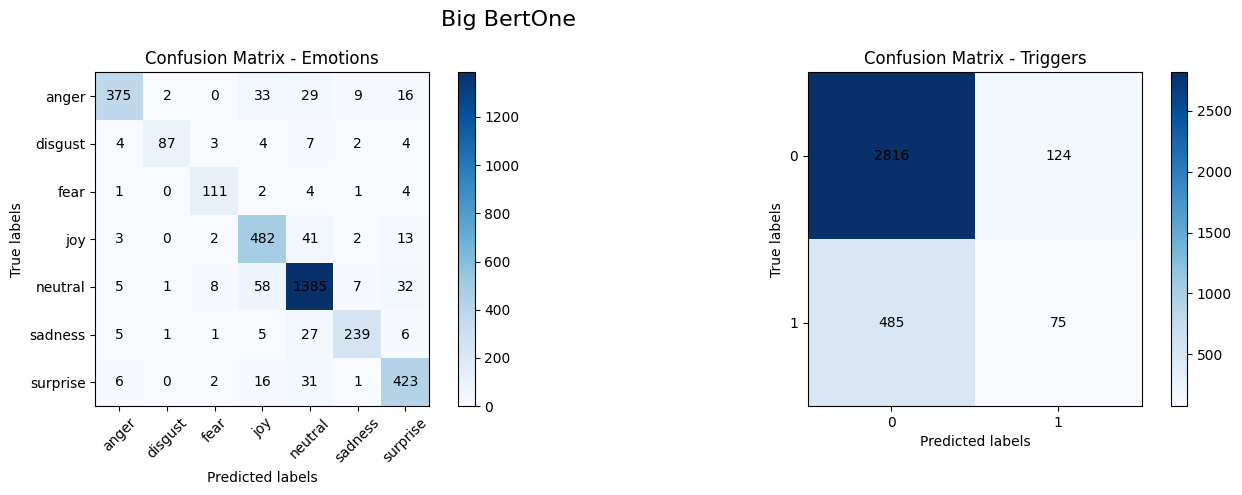

In [50]:
print('Confusion matrices of the model')
plot_confusion_matrix(target_emotions=big_bertOne_results_df['emotions'], 
                      pred_emotions=big_bertOne_results_df['pred_emotions'],
                      emotion_to_index_map=EMOTIONS_TO_IDX,
                      target_triggers=big_bertOne_results_df['triggers'], 
                      pred_triggers=big_bertOne_results_df['pred_triggers'],
                      title='Big BertOne')


In addition to the strong improvement in emotion recognition, we can also observe a significant enhancement in the sequence F1 score, indicating that the model performs well even on long dialogues. In terms of trigger detection, there are no significant improvements, as expected, but the model does indeed perform better in this aspect as well.

In [51]:
display(big_bertOne_unrolled_and_sequence_f1_df)
display(big_bertOne_f1_per_dialogue_df)
display(big_bertOne_emotions_f1_per_class_df)
display(big_bertOne_triggers_f1_per_class_df)


,big_bertone_scores
metrics,
unrolled emotion F1 scores,0.874451
unrolled trigger F1 scores,0.549952
sequence emotion F1 score,0.814436
sequence trigger F1 score,0.529981


,big_bertOne_emotion_f1,big_bertOne_trigger_f1
episode,,
utterance_3881,0.200680,0.454545
utterance_2848,0.586667,0.354067
utterance_1603,1.000000,0.458333
utterance_160,1.000000,0.428571
utterance_1704,1.000000,0.444444
...,...,...
utterance_1130,0.700000,0.444444
utterance_1294,1.000000,0.466667
utterance_860,0.666667,1.000000


,big_bertone_scores
emotions,
anger,0.869061
disgust,0.861386
fear,0.888000
joy,0.843395
neutral,0.917219
sadness,0.877064
surprise,0.865031


,big_bertone_scores
triggers,
0,0.902275
1,0.197628


### Comparison with Freezed and Full Bert


In [52]:
utterance = "utterance_1028"

print(f"Bert Freezed performance on {utterance}:")
emotion_metric = f1_per_dialogue_df.loc[utterance]["freezed_bertOne_emotion_f1"]
trigger_metric = f1_per_dialogue_df.loc[utterance]["freezed_bertOne_trigger_f1"]
print(f"Emotion F1 score: {emotion_metric} \nTrigger F1 Score: {trigger_metric}\n")

print(f"Bert Full performance on {utterance}:")
emotion_metric = f1_per_dialogue_df.loc[utterance]["full_bertOne_emotion_f1"]
trigger_metric = f1_per_dialogue_df.loc[utterance]["full_bertOne_trigger_f1"]
print(f"Emotion F1 score: {emotion_metric} \nTrigger F1 Score: {trigger_metric}\n")

print(f"Big Bertone performance on {utterance}:")
emotion_metric = big_bertOne_f1_per_dialogue_df.loc[utterance]["big_bertOne_emotion_f1"]
trigger_metric = big_bertOne_f1_per_dialogue_df.loc[utterance]["big_bertOne_trigger_f1"]
print(f"Emotion F1 score: {emotion_metric} \nTrigger F1 Score: {trigger_metric}")
display_dialogue(dataframe=big_bertOne_results_df, utterance_id=utterance, verbose=False)


Bert Freezed performance on utterance_1028:
Emotion F1 score: 0.4404761904761904 
Trigger F1 Score: 0.2874493927125506

Bert Full performance on utterance_1028:
Emotion F1 score: 0.45598845598845594 
Trigger F1 Score: 0.5

Big Bertone performance on utterance_1028:
Emotion F1 score: 1.0 
Trigger F1 Score: 0.4074074074074074


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Ross,anger,What difference does that make?!,0,anger,0
1,Joey,anger,"Well, I'm justif the paste matches the pants,...",0,anger,0
2,Rachel,neutral,"Joey, do you have a minute?",0,neutral,0
3,Ross,fear,"Dude, what am I gonna",0,fear,0
4,Joey,anger,"Uh, Rachel's here, so good luck man, let me kn...",0,anger,0
5,Rachel,fear,"Oh, Joey, I have such a problem!",0,fear,0
6,Joey,neutral,"Oh well, you're timing couldn't be better. I a...",0,neutral,0
7,Rachel,neutral,"Okay. Okay. Okay. Joey, I have",0,neutral,0
8,Joey,neutral,"What-what is it, what is it?",0,neutral,0
9,Rachel,surprise,"Oh my God, it's so huge, but you just have to ...",0,surprise,1
